## Introduction

## Goals
* Reveal the idea of gradient boosting
* Test gradient boosting method on classification and ranging problem
* Compare gradient boosting to random forest
* Consider of different implementations of gradient boosting

## Gradient boosting: the main idea and approach

Gradient boosting is fastier alternative to <b>bagging</b> method of composing (ensembling) ML models. The main idea of boosting is consequent building of <b>base models</b> (it doesn't have to be trees) each of them corrects errors of all the previous. As like bagging, boosting as an answer has aggregation of answers of base models.

### Formal approach of boosting in ML and example

Let's pretend that we are solving a regression problem on a train dataset $(X, y)$. We are training a model $a(X)$ which is a composition of base models $b_n(X)$. Let's pretend that the composition builds by summing of answers of the base models:
$$a(X) = \sum_{n=1}^{N} b_n(X)$$
As a base model we use decision tree with depth equals one (just an example, not rule).

<b>Note</b>: It is believed that one of the most powerful and universal machine learning methods at the moment is boosting with decision trees. Following this tradition we consider here boosting with decision trees. However, it is important to understand that boosting is an approach that can be built on any model, which we will also pay attention to.

We will solve the problem by minimizing the mean square error:
$$\frac{1}{\ell} \sum_{i=1}^{\ell} (a(x_i) - y_i)^2 \rightarrow \min_{a}$$

In this example we deal with only train dataset (just an example). For building a composition of models idea of gradient boosting is used.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

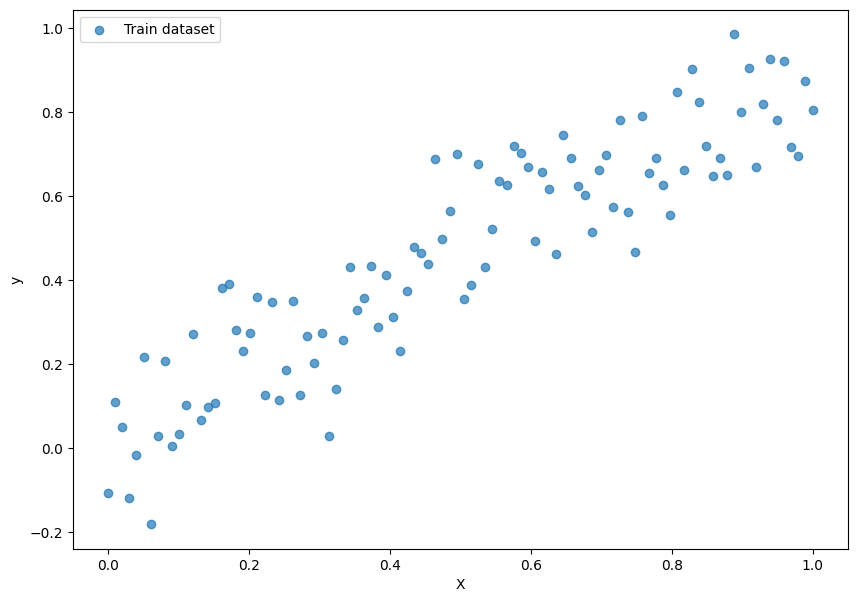

In [2]:
# Generation of dataset
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size=N)


# Visualization dataset and predictions function
def plot_sample_model(
    X, y, plot_predictions=False, y_pred=None, y_pred_label=None, loss="mse"
):
    plt.figure(figsize=(10, 7))
    plt.scatter(X, y, label="Train dataset", alpha=0.7)
    if plot_predictions:
        plt.plot(X, y_pred, label=y_pred_label, c="r")
        if loss == "mse":
            plt.title("MSE: " + str(mean_squared_error(y, y_pred)))
        elif loss == "mae":
            plt.title("MAE: " + str(mean_absolute_error(y, y_pred)))
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()


plot_sample_model(X, y, plot_predictions=False)

Now let's start building.

<b>Step 0</b>: Empty composition of decision trees $a(X) = \{\}$.

In [3]:
a = 0

<b>Step 1</b>: Training the first decision tree $DT_1$ with depth equals 1 and add it to the composition $a(X) = DT_1$. Get predictions of the composition on the train datset.

In [4]:
from sklearn.tree import DecisionTreeRegressor

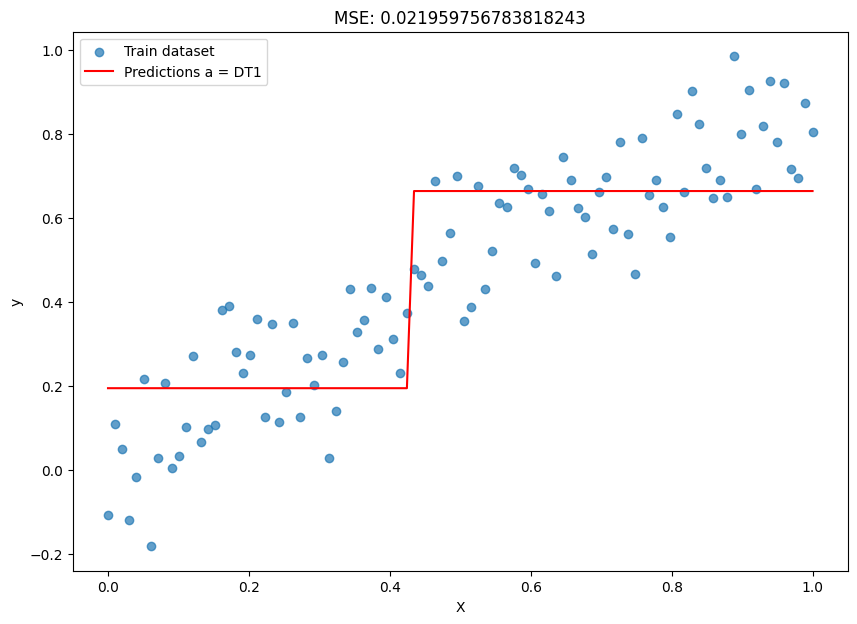

In [5]:
DTR = DecisionTreeRegressor(max_depth=1)
DTR.fit(X, y)
a = DTR.predict(X)

plot_sample_model(
    X, y, plot_predictions=True, y_pred=a, y_pred_label="Predictions a = DT1"
)

<b>Step 2</b>: As errors <b>residuals</b> is used. Residuals is distance from predictions of composition to ground truth values.
$$s^{(1)}(X) = y - a^{(1)}(x)$$

Note that $MSE$ (the most common loss function for regression problems) is average sum of squares of residuals and residuals is natural representation of error: if we add the residuals to model answers, then we reach zero mean square error. Thus, it's logical to build a next model so that it quite well predicts residuals of the composition: if we add predictions of the second model (predcited residuals) to predictions of the first we achieve decreasing of the error.

In [6]:
s1 = y - a

<b>Step 3</b>: Let's train the secongd decision tree $DT_2$ predicting residuals. Let's add predictions of the second tree to the composition:
$$a^{(2)}(X) = DT_1 + DT_2$$
Then we obtain predictions of the composition on the train dataset.

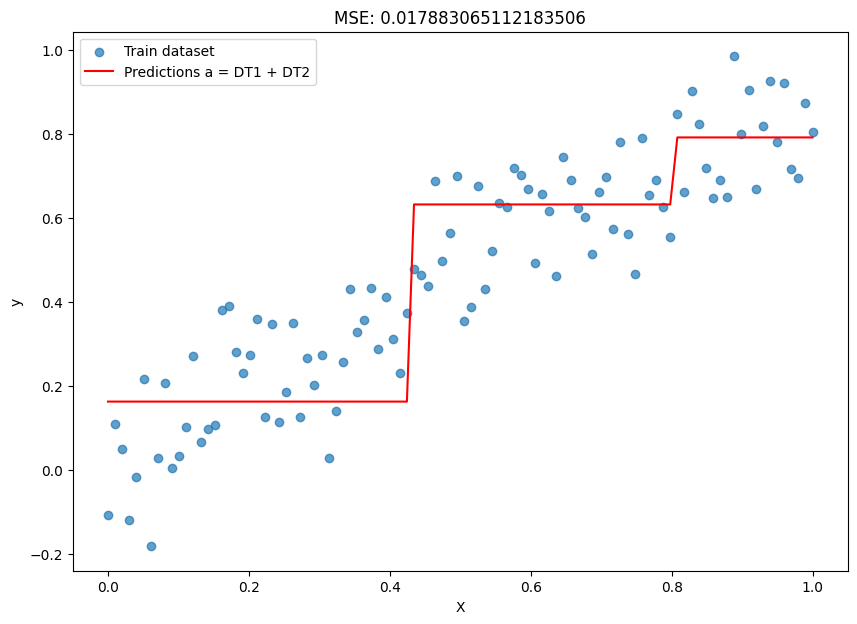

In [7]:
DTR = DecisionTreeRegressor(max_depth=1)
DTR.fit(X, s1)


a += DTR.predict(X)

plot_sample_model(
    X, y, plot_predictions=True, y_pred=a, y_pred_label="Predictions a = DT1 + DT2"
)

The surface become more complicated and it aprroximates the train datset more precisely. 

<b>Steps 4 and further</b>: Repeat the process some times (we repeat just ones).

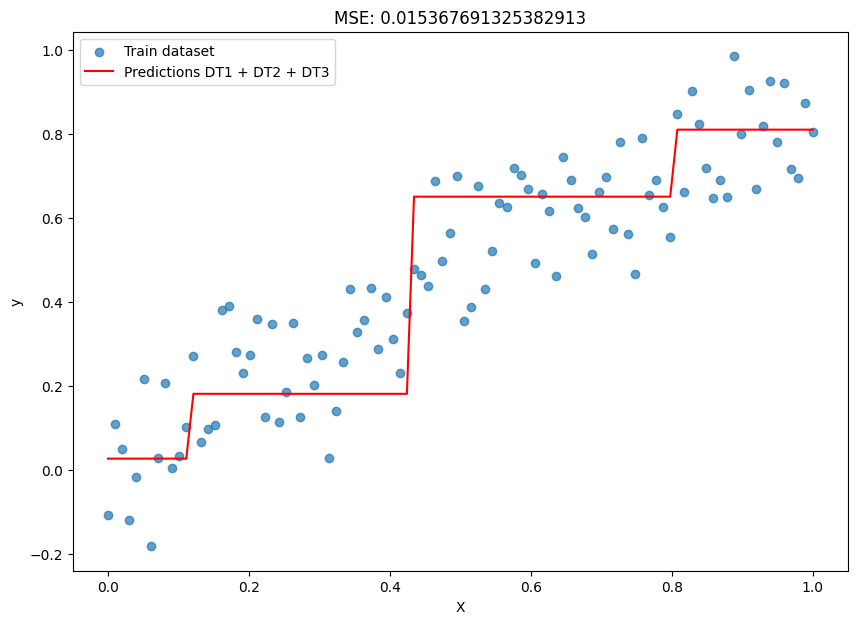

In [8]:
s2 = y - a

DTR = DecisionTreeRegressor(max_depth=1)
DTR.fit(X, s2)
a += DTR.predict(X)

# Визуализация выборки и предсказаний
plot_sample_model(
    X, y, plot_predictions=True, y_pred=a, y_pred_label="Predictions DT1 + DT2 + DT3"
)

As you can see, adding of base models makes decision surface more complicated and it approximates train dataset better and better.

<b>Important</b>: Note that while training the current base model, the composition of the previous step is fixed. It means that training of a new model doesn't influence on already trained models included into the composition.

## Boosting over different models

With `plot_boosting_results()` you can visualize decision surfaces, current base models and residuals after adding of base moels.

In [9]:
def plot_boosting_results(base_estimator, n_estimators, X, y):
    fig, ax = plt.subplots(n_estimators, 3, figsize=(20, n_estimators * 5))

    # Residuals
    resid = []
    resid.append(y)

    # Predictions of the models
    y_pred = []

    for i in range(n_estimators):
        # Training current base model
        base_estimator.fit(X, resid[-1])

        # Base model predictions
        y_pred.append(base_estimator.predict(X))

        # Calculation of prediction of composition
        a = np.sum(y_pred, axis=0)

        # Calculation of residual
        resid.append(y - a)

        # Предсказания композиции
        ax[i, 0].scatter(X, y, label="Train dataset", alpha=0.7)
        ax[i, 0].plot(X, a, c="red", lw=3, label="Number of trees: " + str(i + 1))
        ax[i, 0].set_title("MSE: " + str(mean_squared_error(y, a)))

        # Предсказания очередной модели
        ax[i, 1].scatter(X, y, label="Train dataset", alpha=0.7)
        ax[i, 1].plot(X, y_pred[-1], c="red", lw=3)
        ax[i, 1].set_title("Predictions of model " + str(i + 1))

        ax[i, 2].scatter(X, resid[-1], alpha=0.7, marker="v", c="orange")
        ax[i, 2].set_title("Residuals")

        ax[i, 0].legend()

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

### Boosting over trees

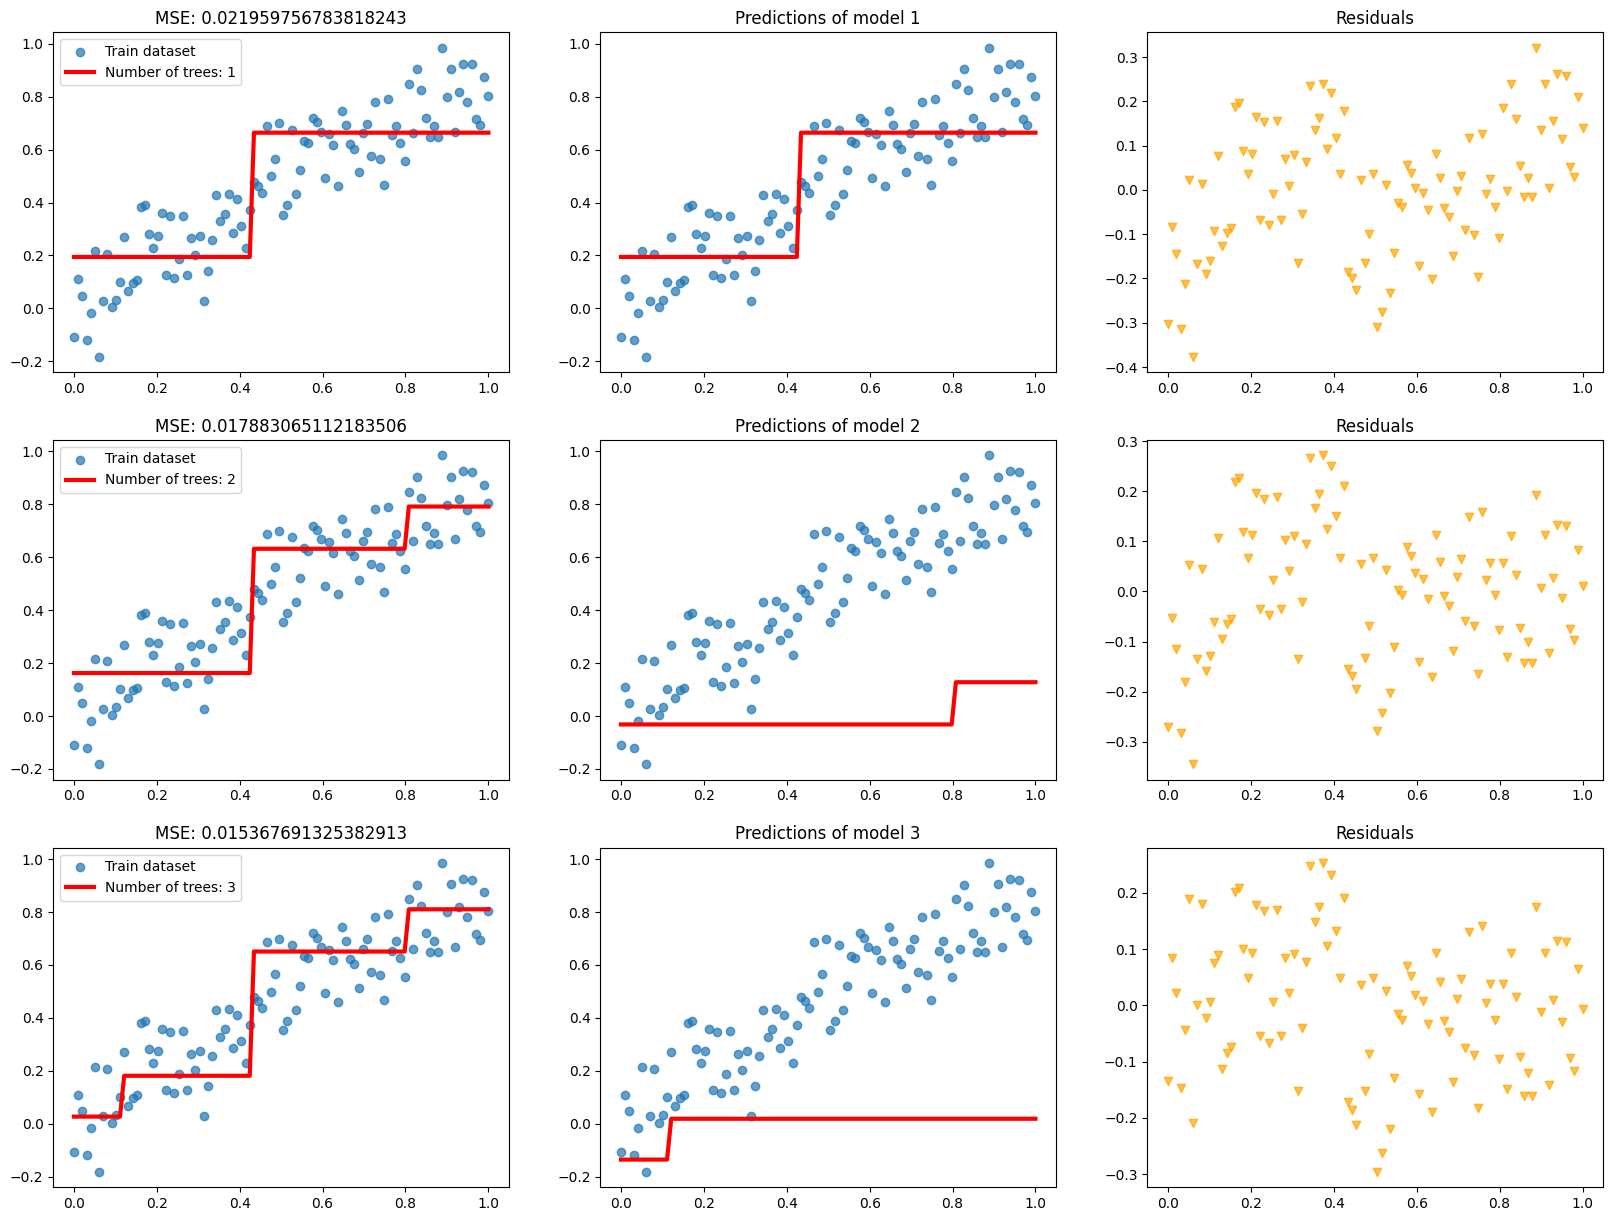

In [11]:
plot_boosting_results(DecisionTreeRegressor(max_depth=1), n_estimators=3, X=X, y=y)

### Boosting over linear regression

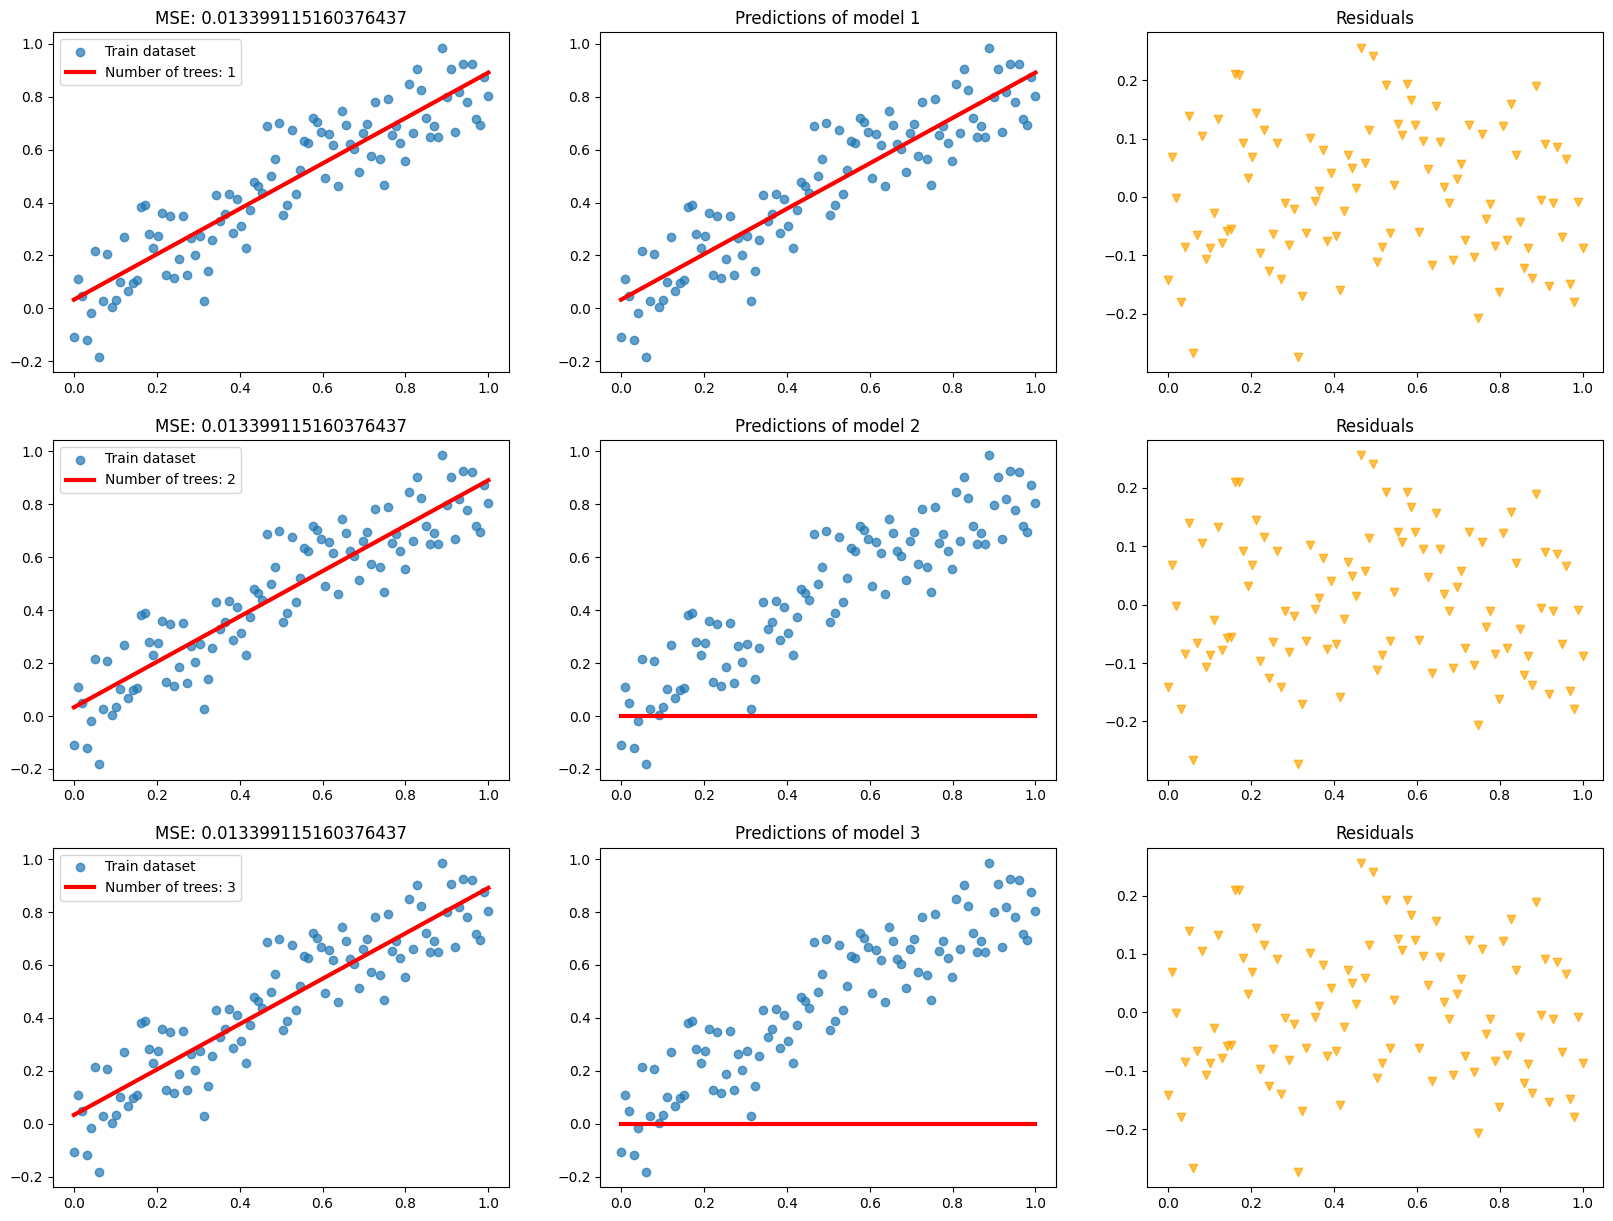

In [12]:
plot_boosting_results(LinearRegression(), n_estimators=3, X=X, y=y)

### Boosting over kNN regression models

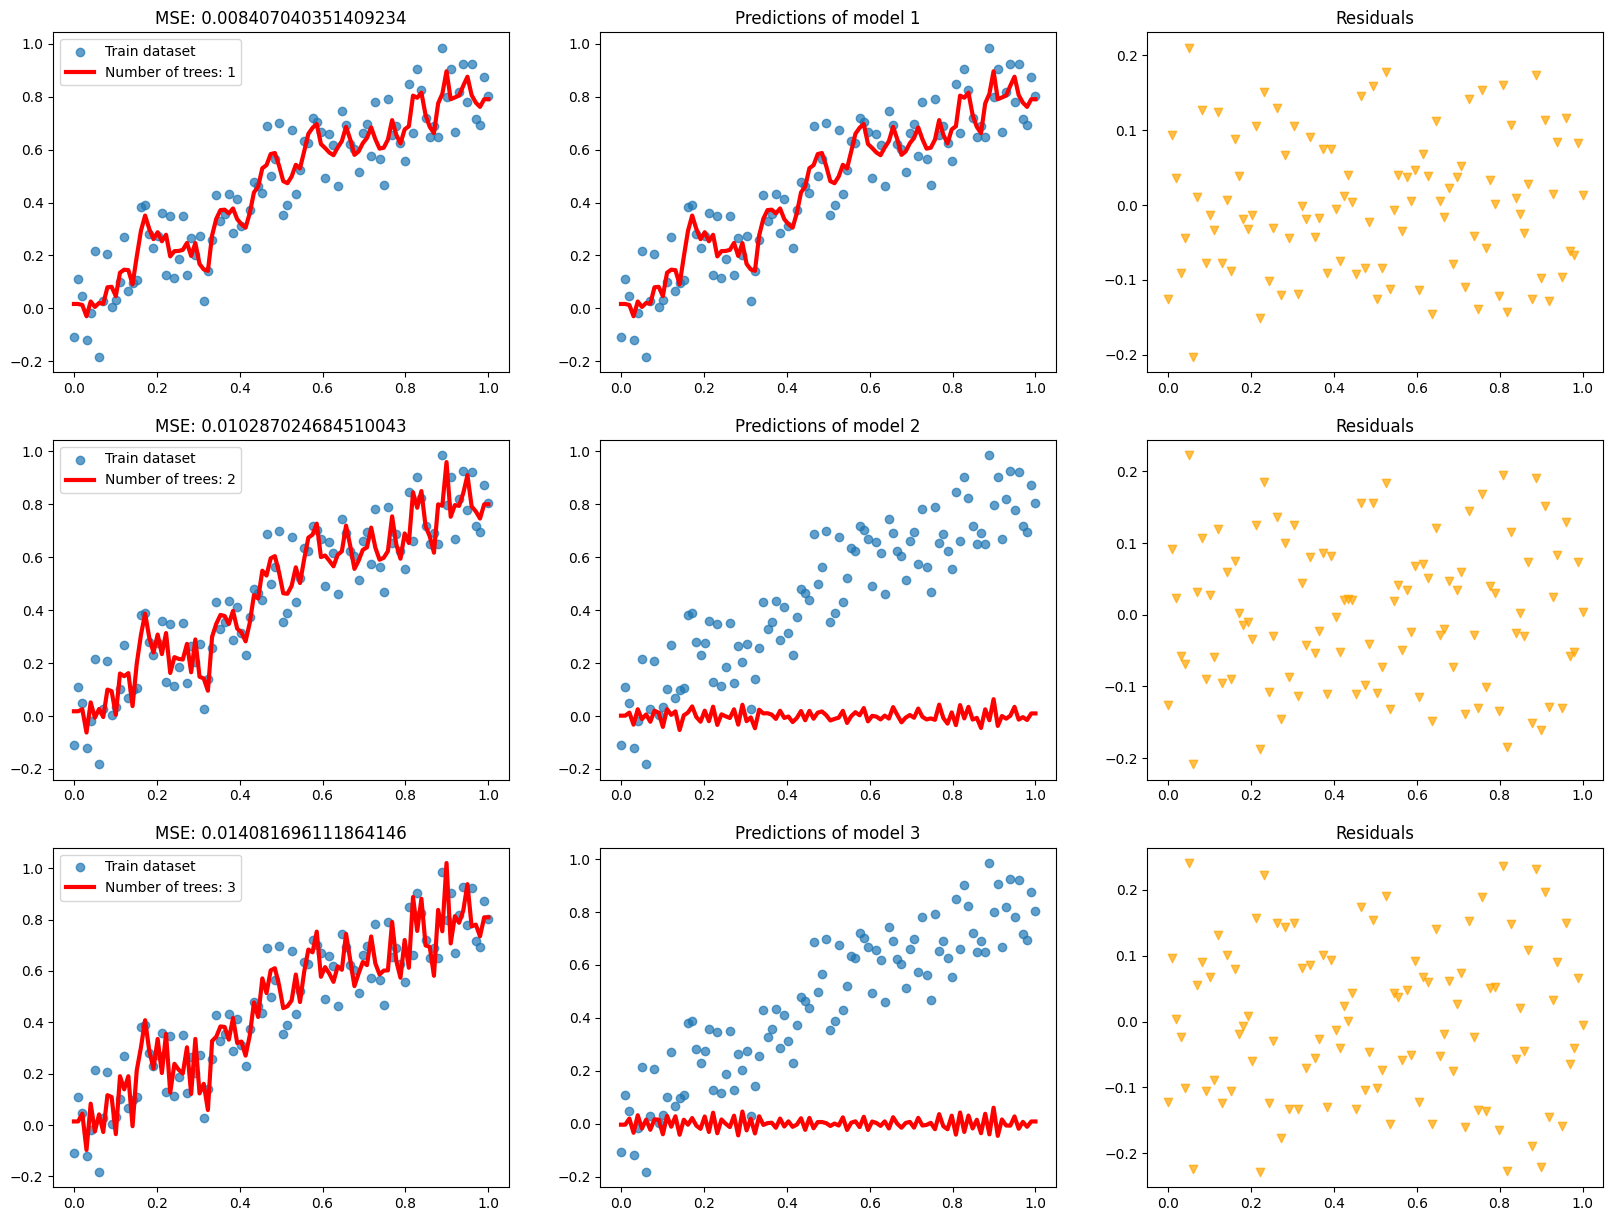

In [13]:
plot_boosting_results(KNeighborsRegressor(3), n_estimators=3, X=X, y=y)

### Boosting over SVR regressor

C:\Users\akalyuzhin\Workenv\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\akalyuzhin\Workenv\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\akalyuzhin\Workenv\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


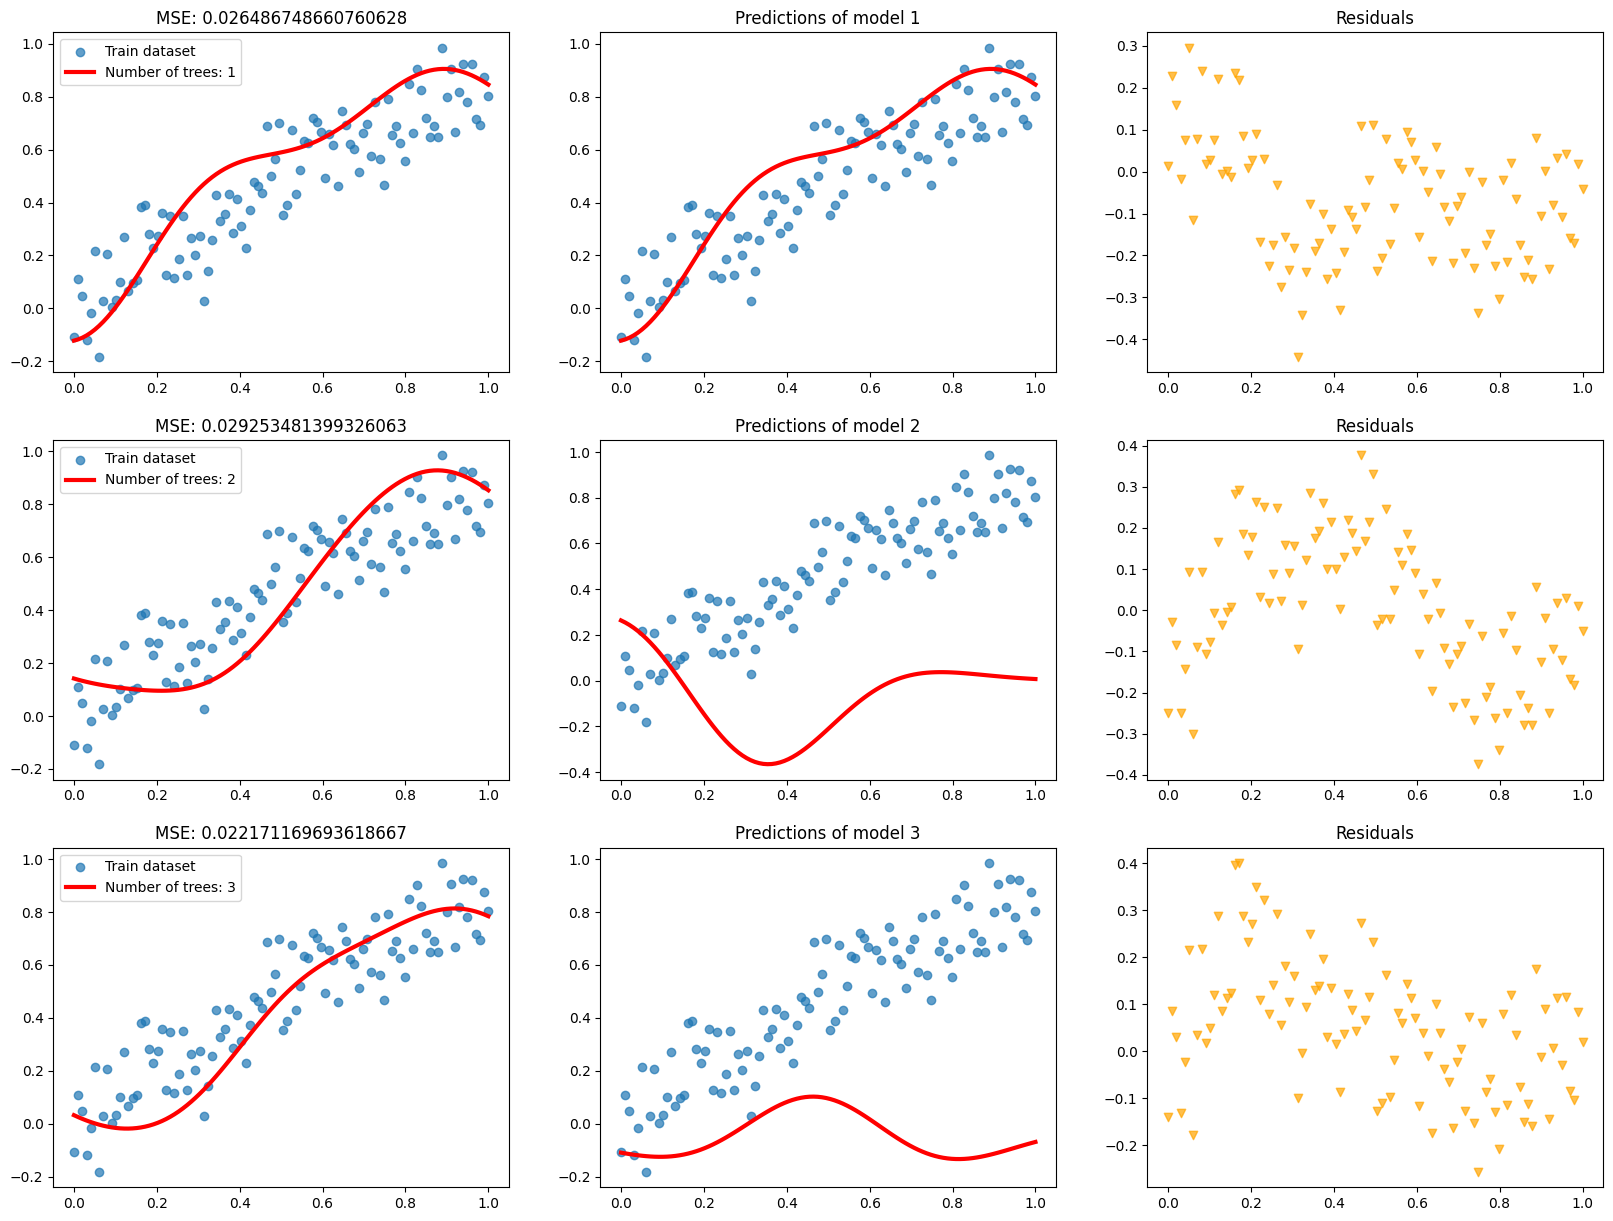

In [14]:
plot_boosting_results(SVR(max_iter=5), n_estimators=3, X=X, y=y)

## Gradient boosting

Note that in the exapmle above using residuals as measure of error was justified because the residuals directly involved in the calculation of $MSE$. Now let's try to genralize the idea of using the residuals on an arbitrary loss function.

Let's solve the same problem as above but with arbitrary loss functions $L(.)$. Let's pretend that some way we already trained $N$ base models and built a composition $a^{(N)(X)}$. So, how to build $(N+1)$ base model?

Note that we want to choose $(N+1)$ base model so that as strong as possible to decrease loss:
$$\frac{1}{\ell} \sum_{i=1}^{\ell} L[y_i, a^{(N)(x_i)} + b^{(N+1)}(x_i)] \rightarrow \min_{b^{(N+1)}}$$

where $b^{(N+1)}(x_i)$ is the prediction of a new base model. Now note that because both $y_i$ and $a^{(N)(x_i)}$ are fixed  then we need to find a numbers $b^{(N+1)}(x_i) = s_{i}^{N}$ which reduce the loss function the most.
$$ \frac{1}{\ell} \sum_{i=1}^{\ell} L[y_i, a^{(N)(x_i)} + s_{i}^{(N)}] \rightarrow \min_{s_{i}^{(N)}}$$

<b>Note</b>: We are searching for just numbers $s_{i}^{N}$ which which reduce the loss function the most.

Now, as we know, a vector of the maximal redusing of some function is its antigradient.
Then, as $s_{i}^{N}$ we should take:
$$ s_{i}^{N} = \left. -\frac{\partial L(y, p)}{\partial p} \right|_{p=a^{(N)}(x_i)}$$

Thus $s_{i}^{(N)}$ is antigradient of the loss function in point of answers of the already built composition.

Thus we need to train current base model so that it approximate of antigradient of the loss function in point of answers of the already built composition - and it's well-known to us supervised learning problem. It's usually solves by using $MSE$.

$$b^{}(x) = \arg \min_{b} \sum_{i=1}^{\ell} (b(x_i) - s_{i}^{(N)})^2$$

<b>$\underline{\text{Important}}$</b>: The problem described above it isn't the initial problem. We can use any loss function and through it deduse $s_{i}^{(N)}$ and then just solve the approximation problem with $MSE$.

### Previous example with gradient boosting

Let's repeat the steps from previous example but with <b>gradient</b> boosting. We were solving a regression problem via $MSE$ minimization.

Zero and first step in the examples are the same.

<b>Step 0</b>: Empty composition of decision trees $a(X) = \{\}$.

In [15]:
a = 0

<b>Step 1</b>: Training the first decision tree $DT_1$ with depth equals 1 and add it to the composition $a(X) = DT_1$. Get predictions of the composition on the train datset.

In [16]:
from sklearn.tree import DecisionTreeRegressor

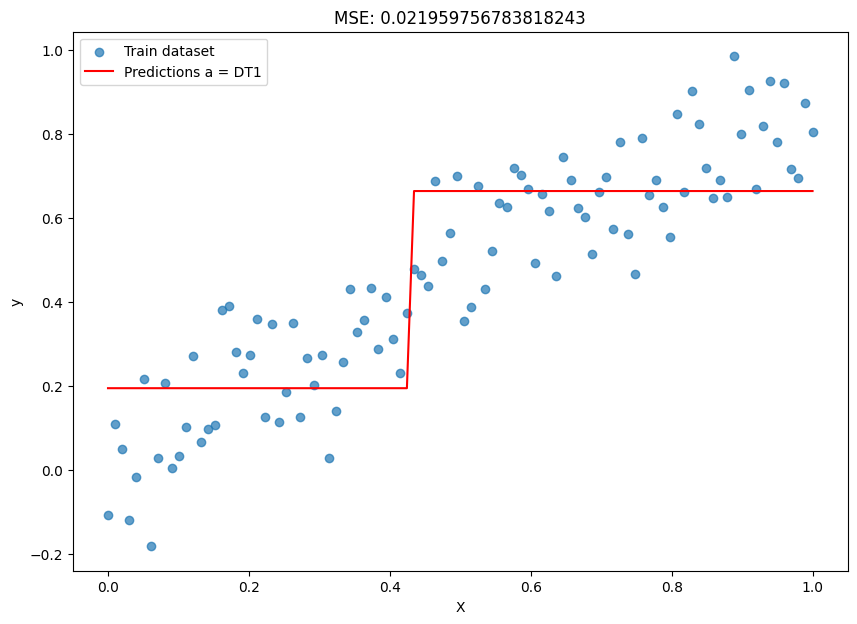

In [17]:
dt1 = DecisionTreeRegressor(max_depth=1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

a = dt1_pred

plot_sample_model(
    X, y, plot_predictions=True, y_pred=a, y_pred_label="Predictions a = DT1"
)

<b>Step 2</b>: Here we were calculating the residuals before. But now we are calculating the antigradient of the loss function in point of answers of the already built composition.

We have
$$ L(y, p) = \frac{1}{2}\sum_{i=1}^{\ell} (y_i - p_i)^2$$
where $p_i = a(x_i)$

Then
$$ \left. \frac{\partial L(y,p)}{\partial p} \right|_{p_i = a(x_i)} = -(y_i - a(x_i))$$
then
$$s_{i} = \left. -\frac{\partial L(y,p)}{\partial p} \right|_{p_i = a(x_i)} = y_i - a(x_i)$$

But this is the same residual that we defined in eample above. 

So, if while using gradient boosting you use $MSE$ as a loss function, then using of gradient boosting if equivalent of residuals calculation.

In [18]:
s1 = y - a

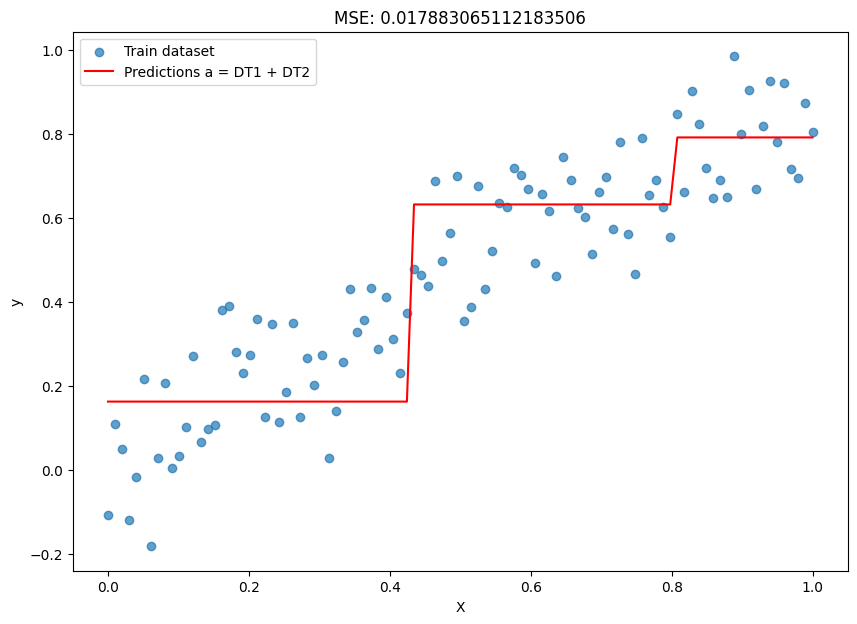

In [19]:
dt2 = DecisionTreeRegressor(max_depth=1)
dt2.fit(X, s1)


dt2_pred = dt2.predict(X)

a += dt2_pred

plot_sample_model(
    X, y, plot_predictions=True, y_pred=a, y_pred_label="Predictions a = DT1 + DT2"
)

<b>Steps 3 and further</b>: Training of the base model predicting antigradient $s_i$. But because $s_i$ and residuals are the same thing because of using $MSE$ as a loss function, we have the same steps as in the previous example.

## Loss functions for gradient boosting in regression and classification problems

### Regression

For regression as a loss function usually use:
* $MSE$
  $$ L(y, p) = \dfrac{1}{2} \sum_{i=1}^{\ell} (y_i - p_i)^2 $$
  where $p_i = a(x_i)$, so $s_{i}^{(N)} = y_i - a^{(N-1)}(x_i)$
  
* $MAE$
  $$ L(y, p) = \sum_{i=1}^{\ell} |y_i - p_i| $$
  where $p_i = a(x_i)$, so $s_{i}^{(N)} = -sign(a^{(N-1)}(x_i) - y_i)$

For $MSE$ an example was considered above, let's consider an example for $MAE$ loss function.

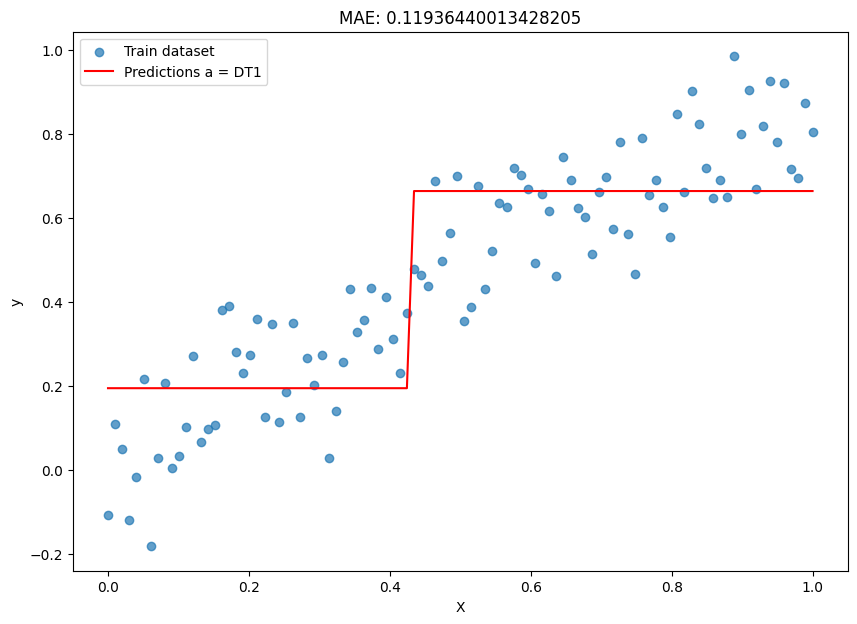

In [20]:
# Initialization
a = 0

# Training of the decision tree of depth equals 1 and getting of predictions on training dataset
dt1 = DecisionTreeRegressor(max_depth=1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Adding of the predictions of the first tree into the composition via summing
a = dt1_pred

# Visualization of the dataset and predictions
plot_sample_model(
    X,
    y,
    plot_predictions=True,
    y_pred=a,
    y_pred_label="Predictions a = DT1",
    loss="mae",
)

In [21]:
# Antigradient calculation 
s1 = -np.sign(a - y)

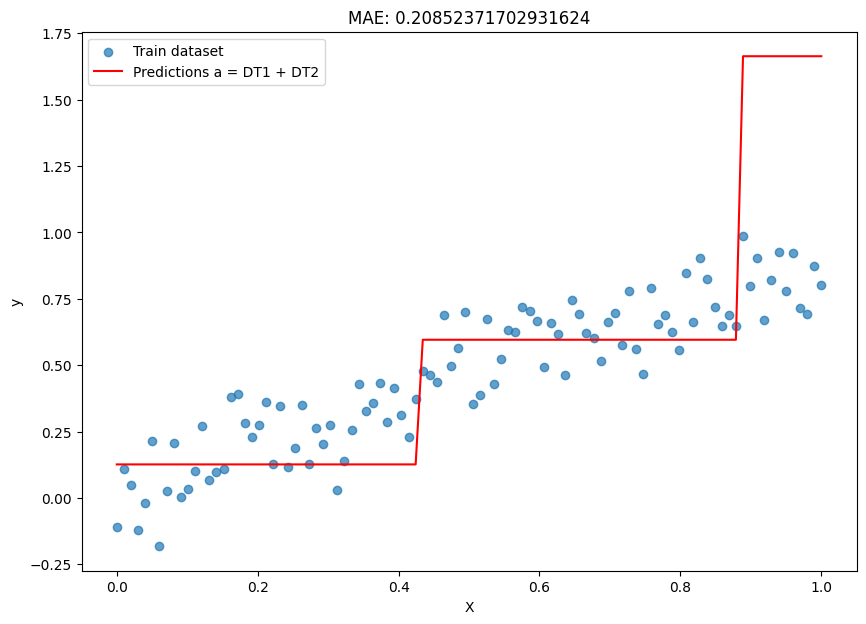

In [22]:
# Training of the second decision tree predicting an antigradient
dt2 = DecisionTreeRegressor(max_depth=1)
dt2.fit(X, s1)

dt2_pred = dt2.predict(X)

a += dt2_pred

plot_sample_model(
    X,
    y,
    plot_predictions=True,
    y_pred=a,
    y_pred_label="Predictions a = DT1 + DT2",
    loss="mae",
)

<b>Note</b>: $MAE$ increased after increasing of number of based models in composition, and the decision surface has a "turn" depending on the constraints of the training choice. We will solve this problem later.

### Classification

In binary classification problems logistic loss function is usually used.
$$ L(y, p) = \ln(1 + e^{-yp})$$
 where $p_i = a(x_i)$
So, then antigradient here is:
$$s_{i}^{N} = \frac{y_i}{1 + e^{y_i a^{(N-1)}(x_i)}}$$

Let's try to do a step of gradient boosting in problem binary classification with logisctic loss function.

In [23]:
from sklearn.datasets import load_iris

In [24]:
data = load_iris()
X = data["data"]
y = data["target"]

# Recode the problem to binary classification problem
y[y == 2] = 1
set(y)

{0, 1}

In [25]:
a = 0

dt1 = DecisionTreeRegressor(max_depth=1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

a = dt1_pred

In [26]:
def log_loss(y, y_pred):
    return np.log(1 + np.exp(-y * y_pred)).mean()

In [27]:
log_loss(y, a)

0.439890185198797

In [28]:
s1 = y / (1 + np.exp(y * a))

In [29]:
dt2 = DecisionTreeRegressor(max_depth=1)
dt2.fit(X, s1)

dt2_pred = dt2.predict(X)

a += dt2_pred

In [30]:
log_loss(y, a)

0.39621023915529535

As you can see, the loss value is decreasing.

## Pecularities of gradient boosting

### Composition buuilding

In the examples above, we built the composition of models by simple summation. It is clear that in general it is possible to construct a weighted sum of basic models:
$$ a(X) = \sum_{n=1}^{k} \omega_n b_n(X)$$

where coefficients $\omega_n$ can be founded, for instance, with gradient descent in:
$$\omega_n = \arg \min_{\omega} \sum_{i=1}^{\ell} L(y_i, a^{(N-1)}(x_i) + \omega \times b_{N}(x_i))$$

it makes sence because $ b_{N}(x_i)$ is already fixed and trained.

<b>Note</b>: Step length is one of the key parameters of gradient boosting, and can greatly affect its performance.

In our case, selecting the correct coefficient will help solve the increase in MAE in the example for classification above.

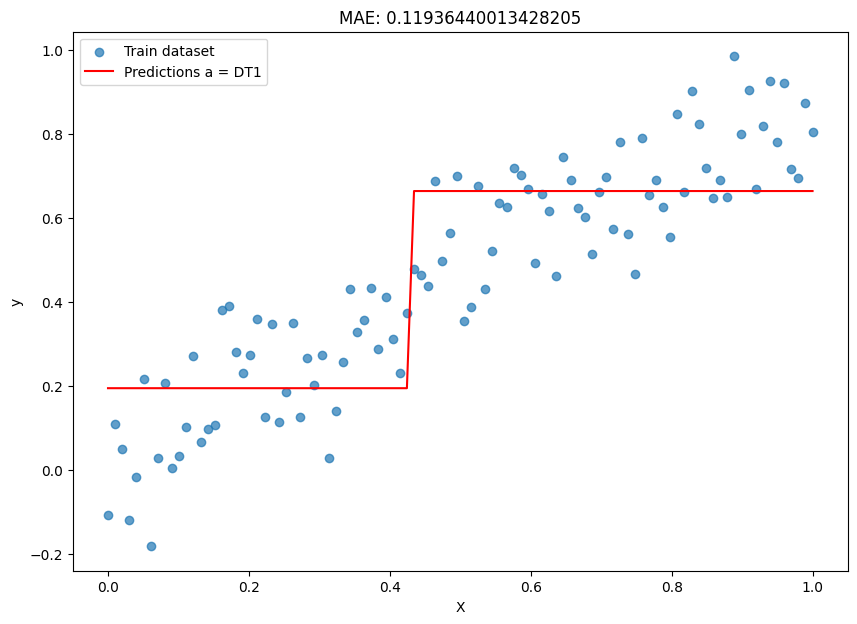

In [31]:
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size=N)
a = 0

dt1 = DecisionTreeRegressor(max_depth=1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

a = dt1_pred

plot_sample_model(
    X,
    y,
    plot_predictions=True,
    y_pred=a,
    y_pred_label="Predictions a = DT1",
    loss="mae",
)

In [32]:
# Antigradient calculation
s1 = -np.sign(a - y)

In [33]:
# Here we try to guess the weight so that decrease MAE value 
w = 0.1

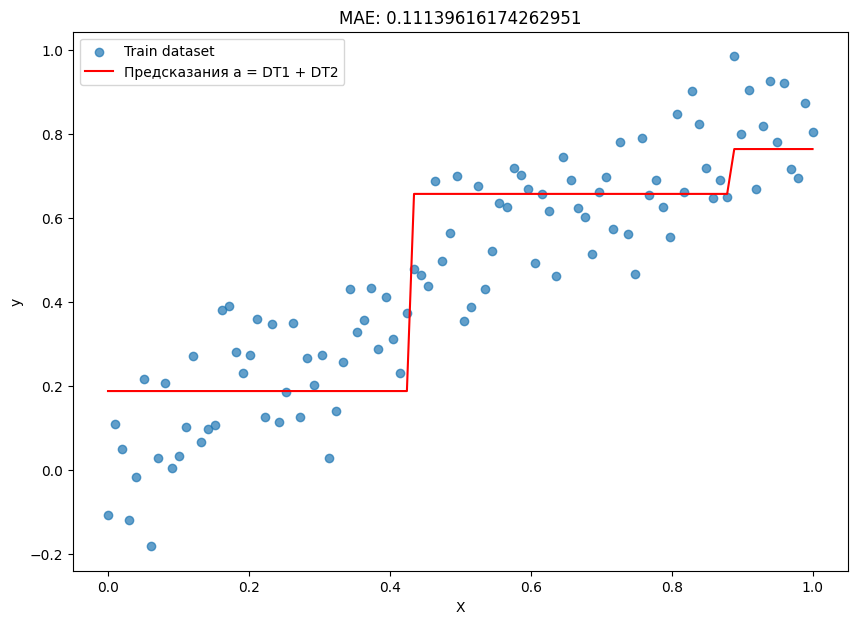

In [34]:
dt2 = DecisionTreeRegressor(max_depth=1)
dt2.fit(X, s1)

dt2_pred = dt2.predict(X)

a += w * dt2_pred

plot_sample_model(
    X,
    y,
    plot_predictions=True,
    y_pred=a,
    y_pred_label="Предсказания a = DT1 + DT2",
    loss="mae",
)

### Overfitting

Recall that in the case of bagging, increasing the number of base models did not lead to overfitting. For example, in a random forest, errors on the training and test samples reached a plateau, starting with a certain number of trees. It is clear that boosting will not have this property by design: when adding new base models, the composition will approximate the training set more and more accurately, which ultimately (often quickly) can lead to overfitting

From this we can conclude that in the case of boosting, the error on the training sample, depending on the number of trees, is a decreasing function, and the error on the test sample most likely has a U-shape. Let’s verify this and compare the behavior of errors and decision surfaces of boosting and random forest.

Hereinafter, we will use the boosting implementation from `sklearn`, which is gradient boosting over trees.

In [35]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [36]:
# Generation of the sample
np.random.seed(123)
X = np.linspace(0, 1, 300).reshape(-1, 1)


def target(a):
    return a > 0.5


y = target(X) + np.random.normal(size=X.shape) * 0.1
y = y[:, 0]

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

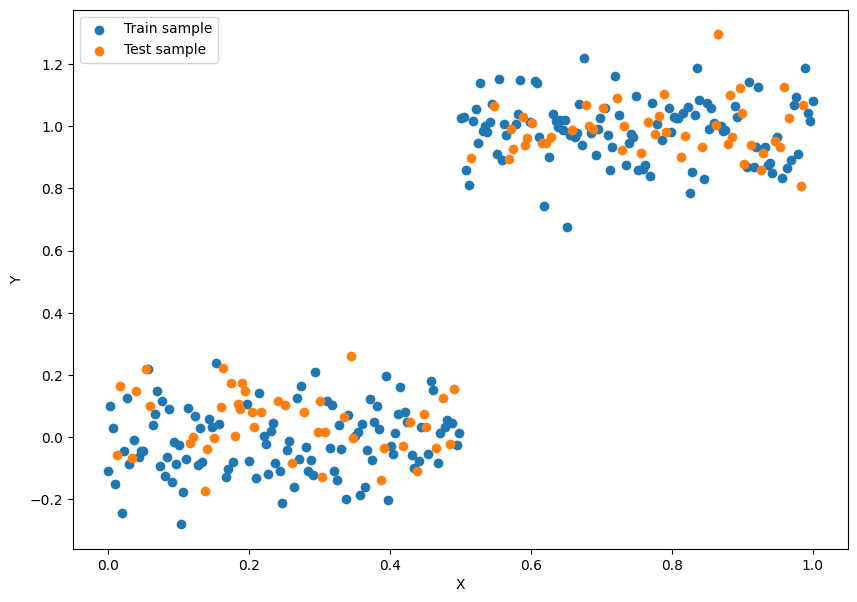

In [38]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, label="Train sample")
plt.scatter(X_test, y_test, label="Test sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

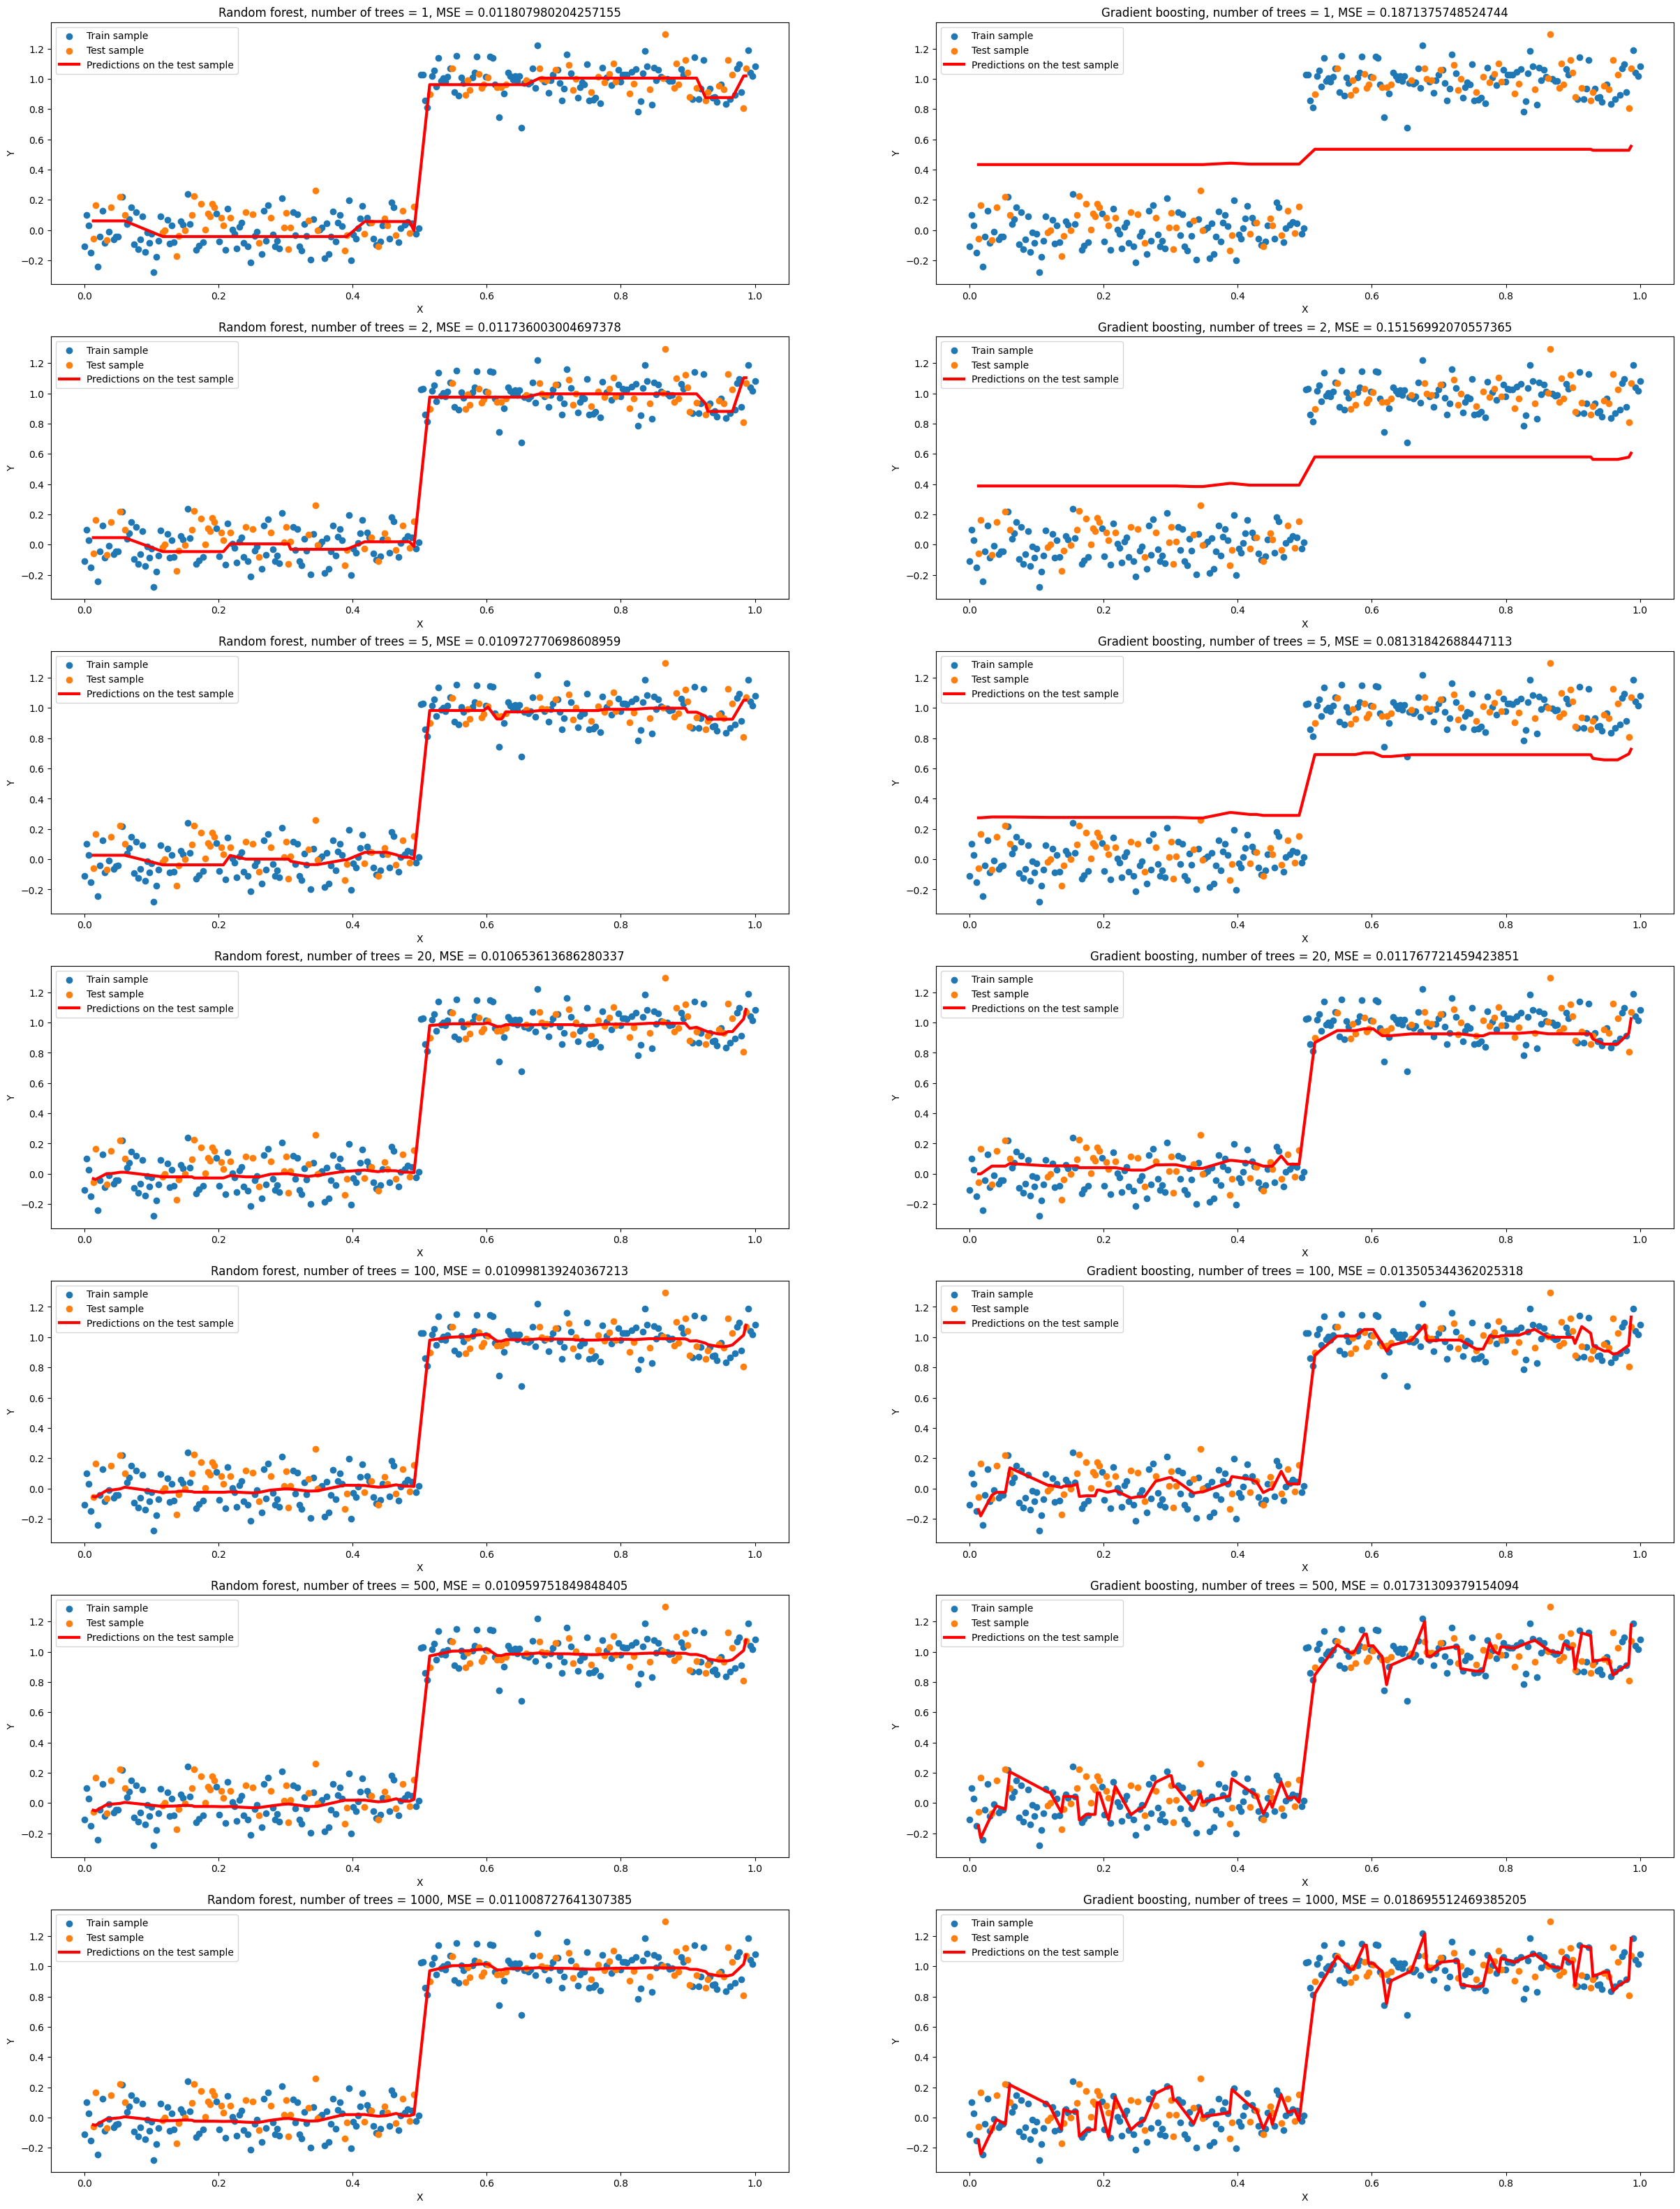

In [39]:
# Visualization of the decision surfaces
trees = [1, 2, 5, 20, 100, 500, 1000]

# Guessed learning rates (magic works only with such a trick)
boosting_learning_rates = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

fig, ax = plt.subplots(len(trees), 2, figsize=(30, 40))

loss_rf_train = []
loss_gb_train = []
loss_rf_test = []
loss_gb_test = []

for i, ts in enumerate(trees):
    rf = RandomForestRegressor(n_estimators=ts, max_depth=3, random_state=123)
    gb = GradientBoostingRegressor(
        n_estimators=ts,
        max_depth=3,
        learning_rate=boosting_learning_rates[i],
        random_state=123,
    )

    rf.fit(X_train, y_train)
    ax[i, 0].scatter(X_train, y_train, label="Train sample")
    ax[i, 0].scatter(X_test, y_test, label="Test sample")
    ax[i, 0].plot(
        sorted(X_test),
        rf.predict(sorted(X_test)),
        lw=3,
        c="red",
        label="Predictions on the test sample",
    )
    ax[i, 0].set_xlabel("X")
    ax[i, 0].set_ylabel("Y")
    ax[i, 0].set_title(
        "Random forest, number of trees = "
        + str(ts)
        + ", MSE = "
        + str(mean_squared_error(y_test, rf.predict(X_test)))
    )
    ax[i, 0].legend()

    loss_rf_train.append(mean_squared_error(y_train, rf.predict(X_train)))
    loss_rf_test.append(mean_squared_error(y_test, rf.predict(X_test)))

    gb.fit(X_train, y_train)
    ax[i, 1].scatter(X_train, y_train, label="Train sample")
    ax[i, 1].scatter(X_test, y_test, label="Test sample")
    ax[i, 1].plot(
        sorted(X_test),
        gb.predict(sorted(X_test)),
        lw=3,
        c="red",
        label="Predictions on the test sample",
    )
    ax[i, 1].set_xlabel("X")
    ax[i, 1].set_ylabel("Y")
    ax[i, 1].set_title(
        "Gradient boosting, number of trees = "
        + str(ts)
        + ", MSE = "
        + str(mean_squared_error(y_test, gb.predict(X_test)))
    )
    ax[i, 1].legend()

    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

As we can see, the decision surface of a random forest changes much less as the number of trees increases than in the case of gradient boosting.

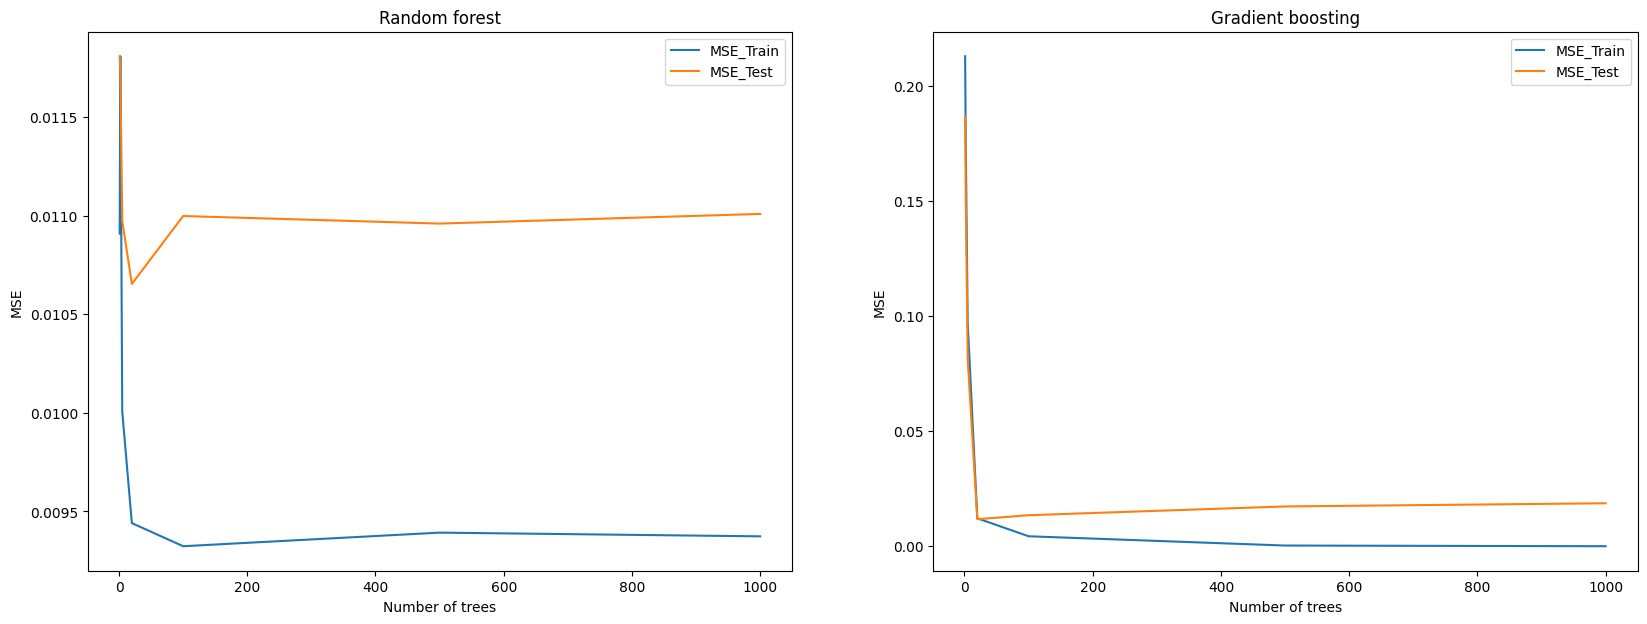

In [40]:
# Errors visualization

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(trees, loss_rf_train, label="MSE_Train")
ax[0].plot(trees, loss_rf_test, label="MSE_Test")
ax[0].set_xlabel("Number of trees")
ax[0].set_ylabel("MSE")
ax[0].set_title("Random forest")
ax[0].legend()

ax[1].plot(trees, loss_gb_train, label="MSE_Train")
ax[1].plot(trees, loss_gb_test, label="MSE_Test")
ax[1].set_xlabel("Number of trees")
ax[1].set_ylabel("MSE")
ax[1].set_title("Gradient boosting")
ax[1].legend();

The error behavior for random forest is the same as what we saw in previous. In the case of boosting, the error on the training set steadily decreases, and on the test set it has a U-shape.

As a method of regularization we can use decreasing of step
$$ a^{(N)}(X) = a^{(N-1)}(X) + \alpha \omega_N b^{(N)}(X) $$
where $\alpha \in (0, 1]$ - learning rate, or stochastic gradient boosting.

<b>$\underline{\text{Important}}$</b>: the examples above demonstrate how quickly boosting can overfit, and how important the selection of hyperparameters is in its case. In this regard, a situation may arise that gradient boosting with default parameters shows poorer quality than, for example, random forest with default parameters, but a well-tuned gradient boosting usually surpasses random forest in quality. The specific implementation of boosting is also important.

### Couple of words about dispersion and bias

Recall that in the random forest we took pretrained trees as base models, motivating this by the fact that bagging would allow us to maintain a low bias and at the same time reduce variance. Build boosting works in the opposite way: the composition has lower bias than the base models, but the same or greater variance (recite the boosting build sequence again and you will see why this is so). Therefore, models with high bias and low variance are usually used as base models for boosting - as we know, such models are undertrained - for example, shallow decision trees.

## Testing of gradient boosting on the different datasets

Here we try to test gradient boosting on the different datasets and compare the results to results of the random forest on the same datsets.

<b>$\underline{\text{Important}}$</b>: most likely, boosting with default hyperparameters will show poorer quality than random forest with default hyperparameters - the selection of hyperparameters plays a key role in boosting. In addition, comparing the various implementations of the gradient boosting shows that the sklearn implementation may not be the best in quality (debatable issue!). Therefore, always try to conduct as many experiments as possible and select such hyperparameters for boosting in order to surpass the random forest in quality.

## Different implementations of gradient boosting

Previously, to use gradient boosting, you had to implement the algorithm yourself. This was also done in large corporations that used machine learning in their tasks (for example, Microsoft and Yandex). Some of these modified implementations have been released into the open source and most often they are used in practice. Currently the most popular implementations are:

* XGboost + hyperparameters selection
* CatBoost + SHAP
* LightGBM

<center><img src="boosting_roadmap.png"></center>

### XGboost + hyperparameters selection

XGboost codebase based on the article: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

The main XGboost features:
* Base algorithm approximates direction calculated with account of second derivative of the loss function.
* The functional is regularized - fines are added for the number of leaves and for the norm of coefficients
* While tree building criterion of informativity dependent on optimal bias vector is used
* The stopping criterion when training a tree also depends on the optimal bias

Read more: https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture10-ensembles.pdf

In [41]:
import os

import numpy as np
import pandas as pd
from matplotlib import pylab as plot

%pylab inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\akalyuzhin\Workenv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Let's consider of application of this implementation on an example of classification problem: by various characteristics of a customer we'll try to predict whether he/she pay a credit to bank.

In [42]:
X_train = pd.read_csv("train_small.csv")
X_test = pd.read_csv("test_small.csv")
len(X_train), len(X_test)

(24365, 10443)

In [43]:
X_train.head()

,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,Loan_Amount_Submitted_Missing,...,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed,ID
0,0.0,250000.0,5.0,23200,2,3,28,1,1,0,...,0,0,0,0,1,0,1,0,0.0,8161
1,0.0,0.0,0.0,25000,0,0,33,1,1,1,...,0,0,1,0,1,1,0,0,0.0,77530
2,0.0,0.0,0.0,95000,3,7,39,1,1,0,...,0,0,1,0,1,1,0,0,0.0,80633
3,0.0,0.0,0.0,29880,5,3,28,0,0,0,...,0,0,0,0,1,0,1,0,0.0,45059
4,4500.0,100000.0,3.0,30000,5,10,26,0,0,0,...,0,0,1,0,1,1,0,0,0.0,54857


Recall that boosting to show a quite well quality, it's needed carefully select its hyperparameters.

Algorithm of selection of hyperparameters might be the following:
* Selecting relatively large learning_rate ($\eta \in [0.05, 0.3]$), select optimal for given $\eta$ number of trees
* Setting up parameters of trees starting from the most significant ones (max_depth, min_child_weight, gamma, subsample, colsample_bytree)
* Seting up regularizations ($\lambda, \alpha$)
* Decreasing learning_rate, increasing number of trees proportionally.

In [44]:
model_xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=150,
    objective="binary:logistic",
    nthread=-1,
    scale_pos_weight=1,
    seed=27,
)

In [45]:
target = "Disbursed"
IDcol = "ID"

In [46]:
X_train["Disbursed"].value_counts(), len(X_train)

(Disbursed
 0.0    23999
 1.0      366
 Name: count, dtype: int64,
 24365)

Let's create a function for modelling and cross-validation.

This function do the following:
1. Trains the model
2. Calculates accuracy on the train sample
3. Calculate AUC on the train sample
4. Calculate AUC on the test sample
5. Refreshes n_estimators using the cv function built into the xgboost package
6. Builds Feature Importance diagram

In [47]:
from sklearn import metrics


def modelfit(
    alg,
    dtrain,
    dtest,
    predictors,
    useTrainCV=True,
    cv_folds=5,
    early_stopping_rounds=50,
):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(
            xgb_param,
            xgtrain,
            num_boost_round=alg.get_params()["n_estimators"],
            nfold=cv_folds,
            metrics="auc",
            early_stopping_rounds=early_stopping_rounds,
        )
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain["Disbursed"], eval_metric="auc")

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # Print model report:
    print("\nModel Report")
    print(
        "Accuracy : %.4g"
        % metrics.accuracy_score(dtrain["Disbursed"].values, dtrain_predictions)
    )
    print(
        "AUC Score (Train): %f"
        % metrics.roc_auc_score(dtrain["Disbursed"], dtrain_predprob)
    )

    # Predict on testing data:
    dtest["predprob"] = alg.predict_proba(dtest[predictors])[:, 1]
    print(
        "AUC Score (Test): %f"
        % metrics.roc_auc_score(dtest["Disbursed"], dtest["predprob"])
    )

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind="bar", title="Feature Importances")
    plt.ylabel("Feature Importance Score")

Starting of sequent selection of parameters with a large learning_rate.

C:\Users\akalyuzhin\Workenv\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.985
AUC Score (Train): 0.931461
AUC Score (Test): 0.829855


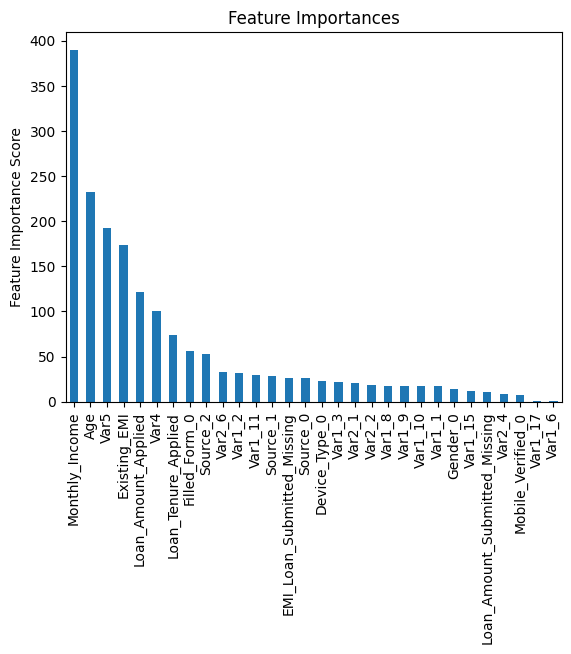

In [48]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

modelfit(model_xgb, X_train, X_test, predictors)

Iterating over max_depth and min_child_weight over the grid.

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
param_test1 = {"max_depth": range(2, 7, 2), "min_child_weight": range(1, 6, 2)}

gsearch1 = GridSearchCV(
    estimator=model_xgb, param_grid=param_test1, scoring="roc_auc", n_jobs=-1, cv=5
)

gsearch1.fit(X_train[predictors], X_train[target])

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 5}, 0.8274289090608191)

Clarifying the prediction.

In [51]:
param_test2 = {"max_depth": [3, 4, 5], "min_child_weight": [2, 3, 4]}

gsearch2 = GridSearchCV(
    estimator=model_xgb, param_grid=param_test2, scoring="roc_auc", n_jobs=-1, cv=5
)

gsearch2.fit(X_train[predictors], X_train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 3}, 0.828948217260183)

Fixing the found max_depth and min_child_weight

In [52]:
model_xgb.max_depth = 5
model_xgb.min_child_weight = 3

We selected max_depth and min_child_weight - we'll use selected values of the parameters. Now we select over the grid gamma parameter on interval from 0 to 1.

In [53]:
param_test3 = {
    'gamma': np.linspace(0, 1, 10)
}

gsearch3b = GridSearchCV(
    estimator=model_xgb, param_grid=param_test3, scoring="roc_auc", n_jobs=-1, cv=5
)

gsearch3b.fit(X_train[predictors], X_train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=73,
                                     n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring='roc_auc')

In [54]:
gsearch3b.best_params_, gsearch3b.best_score_

({'gamma': 0.4444444444444444}, 0.8299918306360592)

Setting as a parameter selected gamma

C:\Users\akalyuzhin\Workenv\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.985
AUC Score (Train): 0.900202
AUC Score (Test): 0.826105


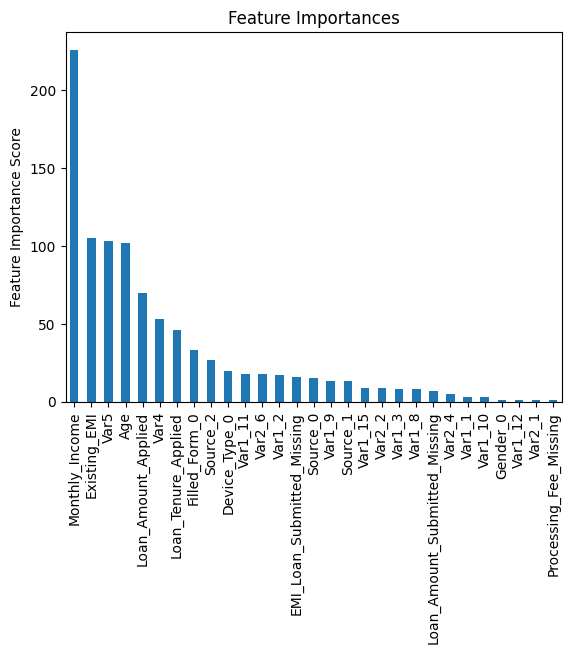

In [55]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

model_xgb.gamma = 0.4444444444444444

modelfit(model_xgb, X_train, X_test, predictors)

Select the subsample and colsample_bytree parameters over the grid. Use the values ​​of these parameters: [0.6, 0.7, 0.8, 0.9, 1.]

In [56]:
param_test4= {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.]
}

gsearch4b = GridSearchCV(
    estimator=model_xgb, param_grid=param_test4, scoring='roc_auc', n_jobs=-1, cv=5
)

gsearch4b.fit(X_train[predictors], X_train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None,
                                     gamma=0.4444444444444444, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learn...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=73,
                                     n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [57]:
gsearch4b.best_params_, gsearch4b.best_score_

({'colsample_bytree': 1.0, 'subsample': 1.0}, 0.8299918306360592)

In [58]:
model_xgb.colsample_bytree = 1.0
model_xgb.subsample = 1.0

Select regularization parameter reg_alpha. Try [1e-5, 1e-2, 0.1, 1, 100]

In [59]:
param_test5= {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5b = GridSearchCV(
    estimator=model_xgb, param_grid=param_test5, scoring='roc_auc', n_jobs=-1, cv=5
)

gsearch5b.fit(X_train[predictors], X_train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=1.0, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None,
                                     gamma=0.4444444444444444, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=73,
                                     n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, ...),
             n_jobs=-1, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [60]:
gsearch5b.best_params_, gsearch5b.best_score_

({'reg_alpha': 1e-05}, 0.830235406155734)

In [61]:
model_xgb.reg_alpha = 1e-05

Start training and prediction on found parameters and take a look on a quality.

C:\Users\akalyuzhin\Workenv\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.985
AUC Score (Train): 0.900202
AUC Score (Test): 0.826105


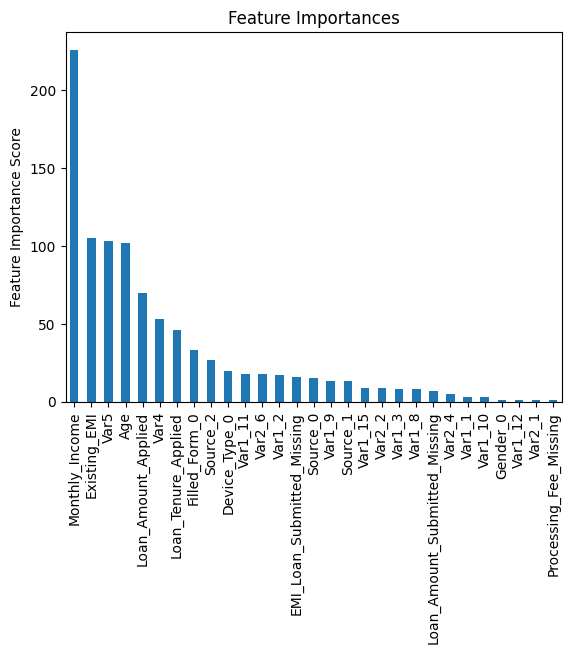

In [62]:
modelfit(model_xgb, X_train, X_test, predictors)

Decrease learning_rate to 0.01 and increase number of trees proportionally. All the selected parameters keeping the same. Train the model and make a prediciton Take a look on quality.

C:\Users\akalyuzhin\Workenv\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.985
AUC Score (Train): 0.907359
AUC Score (Test): 0.829129


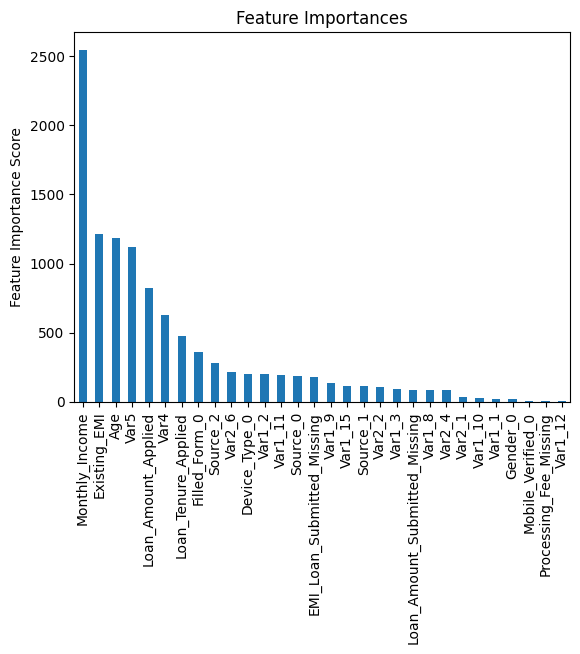

In [63]:
model_xgb.learning_rate = 0.01
model_xgb.n_estimators=1500

modelfit(model_xgb, X_train, X_test, predictors)

### CatBoost

Notebook from official documentation: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Peculiarities:
* Symmetric decision trees are used
* For decoding of categorical features a large set of methods is used
* Dynamical boosting

Thanks to the use of symmetric trees and dynamic boosting, catboost is much more resistant to overfitting than other gradient boosting implementations. Therefore, it shows good quality even with default parameters.

Video about: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+%D0%B0%D0%BD%D0%BD%D0%B0+%D0%B2%D0%B5%D1%80%D0%BE%D0%BD%D0%B8%D0%BA%D0%B0

Installing of the libraries

In [64]:
#!pip install --upgrade catboost
#!pip install --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

In [65]:
from matplotlib import pylab as plt

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\akalyuzhin\Workenv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [66]:
import os

import numpy as np
import pandas as pd

np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

Reading the data. Dataset includes only a categorical features at that with a lot of categories. Features - encoded characteristics of an employee and some resource, target variable - whether an employee an access to the recource.

In [67]:
(train_df, test_df) = catboost.datasets.amazon()

In [68]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Preparing the data

In [69]:
y = train_df.ACTION
X = train_df.drop("ACTION", axis=1)

Creating of the list of categorical features

In [70]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Taking a look on classes ratio 

In [71]:
print("Labels: {}".format(set(y)))
print("Zero count = {}, One count = {}".format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


In catboost abstraction Pool is used. It's an object which includes a matrix object-feature X, vector of answers and the list of numbers of columns with categorical features.

In [72]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool3 = Pool(
    data=FeaturesData(cat_feature_data=X_prepared, cat_feature_names=list(X)),
    label=y.values,
)

print("Dataset shape")
print(
    "dataset 1:"
    + str(pool1.shape)
    + "\ndataset 2:"
    + str(pool2.shape)
    + "\ndataset 3: "
    + str(pool3.shape)
)

print("\n")
print("Column names")
print("dataset 1:")
print(pool1.get_feature_names())
print("\ndataset 2:")
print(pool2.get_feature_names())
print("\ndataset 3:")
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


Dividing the data on train and validation

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, train_size=0.8, random_state=42
)

Let's choose a loss function.

Fro binary classification might be chosen:
* `Logloss`
* `CrossEntropy`

In [75]:
from catboost import CatBoostClassifier

In [76]:
model = CatBoostClassifier(iterations=10, learning_rate=0.1)
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
)
print("Model is fitted: " + str(model.is_fitted()))
print("Model params:")
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 10, 'learning_rate': 0.1}


Printing the results.

In [77]:
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.6189879	test: 0.6185816	best: 0.6185816 (0)	total: 36.2ms	remaining: 326ms
1:	learn: 0.5585149	test: 0.5574616	best: 0.5574616 (1)	total: 81.3ms	remaining: 325ms
2:	learn: 0.5082799	test: 0.5069499	best: 0.5069499 (2)	total: 106ms	remaining: 246ms
3:	learn: 0.4660897	test: 0.4643558	best: 0.4643558 (3)	total: 142ms	remaining: 213ms
4:	learn: 0.4304632	test: 0.4282709	best: 0.4282709 (4)	total: 180ms	remaining: 180ms
5:	learn: 0.4002849	test: 0.3979354	best: 0.3979354 (5)	total: 213ms	remaining: 142ms
6:	learn: 0.3745697	test: 0.3720454	best: 0.3720454 (6)	total: 229ms	remaining: 98.1ms
7:	learn: 0.3525686	test: 0.3498882	best: 0.3498882 (7)	total: 246ms	remaining: 61.5ms
8:	learn: 0.3336944	test: 0.3308677	best: 0.3308677 (8)	total: 255ms	remaining: 28.4ms
9:	learn: 0.3174817	test: 0.3145131	best: 0.3145131 (9)	total: 265ms	remaining: 0us

bestTest = 0.3145131058
bestIteration = 9



Metrics visualization

In [78]:
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison of models

In [79]:
model1 = CatBoostClassifier(
    learning_rate=0.1, iterations=100, random_seed=0, train_dir="learing_rate_0.1"
)

model2 = CatBoostClassifier(
    learning_rate=0.07, iterations=100, random_seed=0, train_dir="learing_rate_0.07"
)
model1.fit(
    X_train,
    y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
)
model2.fit(
    X_train,
    y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
)

Optimal number of decision trees

In [80]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    #     use_best_model=False
)
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [81]:
print("Tree count: " + str(model.tree_count_))

Tree count: 92


Cross-validation

In [82]:
from catboost import cv

In [83]:
params = {}
params["loss_function"] = "Logloss"
params["iterations"] = 80
params["custom_loss"] = "AUC"
params["random_seed"] = 63
params["learning_rate"] = 0.5

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.164632916
bestIteration = 48

Training on fold [2/5]

bestTest = 0.1515742763
bestIteration = 60

Training on fold [3/5]

bestTest = 0.1426916182
bestIteration = 78

Training on fold [4/5]

bestTest = 0.1563234371
bestIteration = 37



In [84]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.227370,0.007679,0.228497,0.005126,0.642263,0.048004
2,2,0.190856,0.006917,0.196796,0.003999,0.791709,0.011361
3,3,0.178884,0.007455,0.186682,0.003242,0.813889,0.009362
4,4,0.172286,0.007957,0.181380,0.002135,0.826529,0.005319


In [85]:
best_value = np.min(cv_data["test-Logloss-mean"])
best_iter = np.argmin(cv_data["test-Logloss-mean"])

print(
    "Best validation LogLoss score, not stratified: {:.4f}±{:.4f} on step {}".format(
        best_value, cv_data["test-Logloss-std"][best_iter], best_iter
    )
)

Best validation LogLoss score, not stratified: 0.1581±0.0104 on step 52


Overfitting detector

In [86]:
model_with_early_stop = CatBoostClassifier(
    iterations=200, random_seed=63, learning_rate=0.5, early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [87]:
print(model_with_early_stop.tree_count_)

21


In [88]:
model_with_early_stop = CatBoostClassifier(
    eval_metric="AUC",
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20,
)
model_with_early_stop.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [89]:
print(model_with_early_stop.tree_count_)

52


Quality metrics calculation and choosing of threshold of decision making

In [90]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(X_train, y_train, cat_features=cat_features, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<center><img src="TP_FT_diagram.png"></center>

In [91]:
import sklearn
from catboost.utils import get_roc_curve
from sklearn import metrics

In [92]:
eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

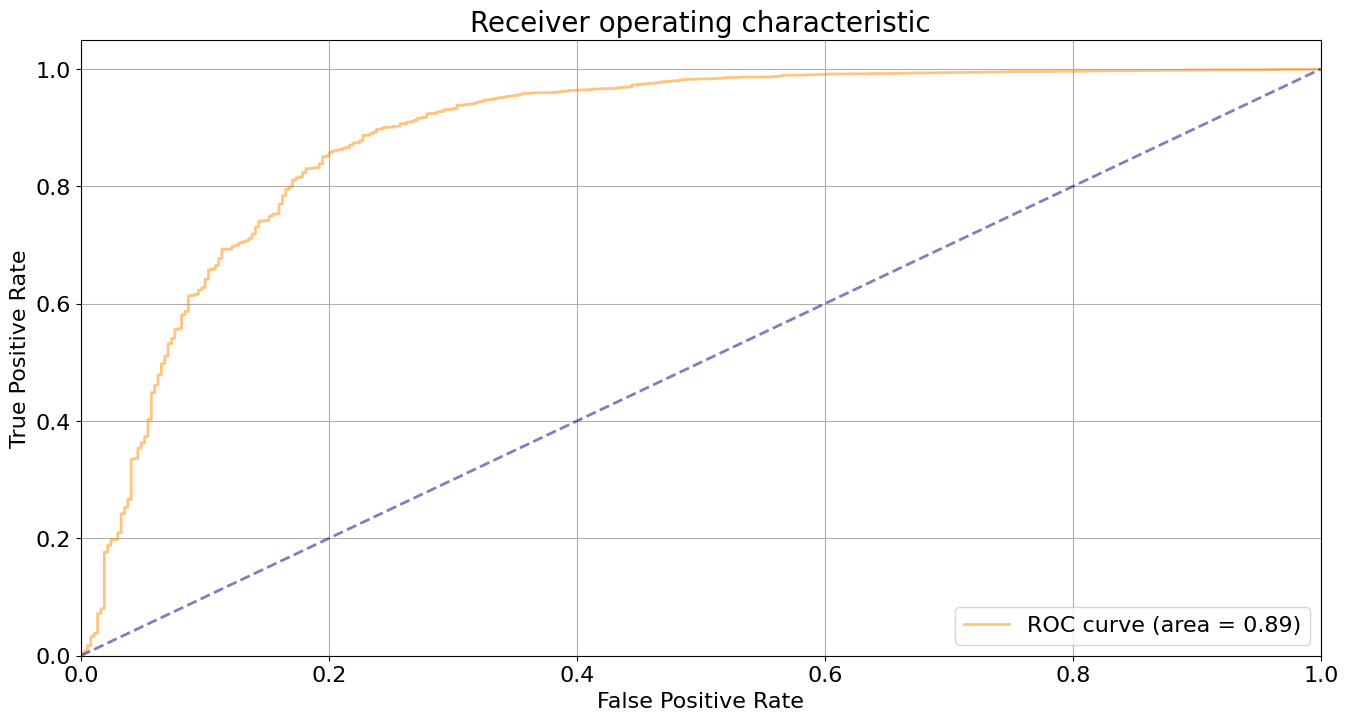

In [93]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
    alpha=0.5,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Receiver operating characteristic", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [94]:
from catboost.utils import get_fnr_curve, get_fpr_curve

In [95]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

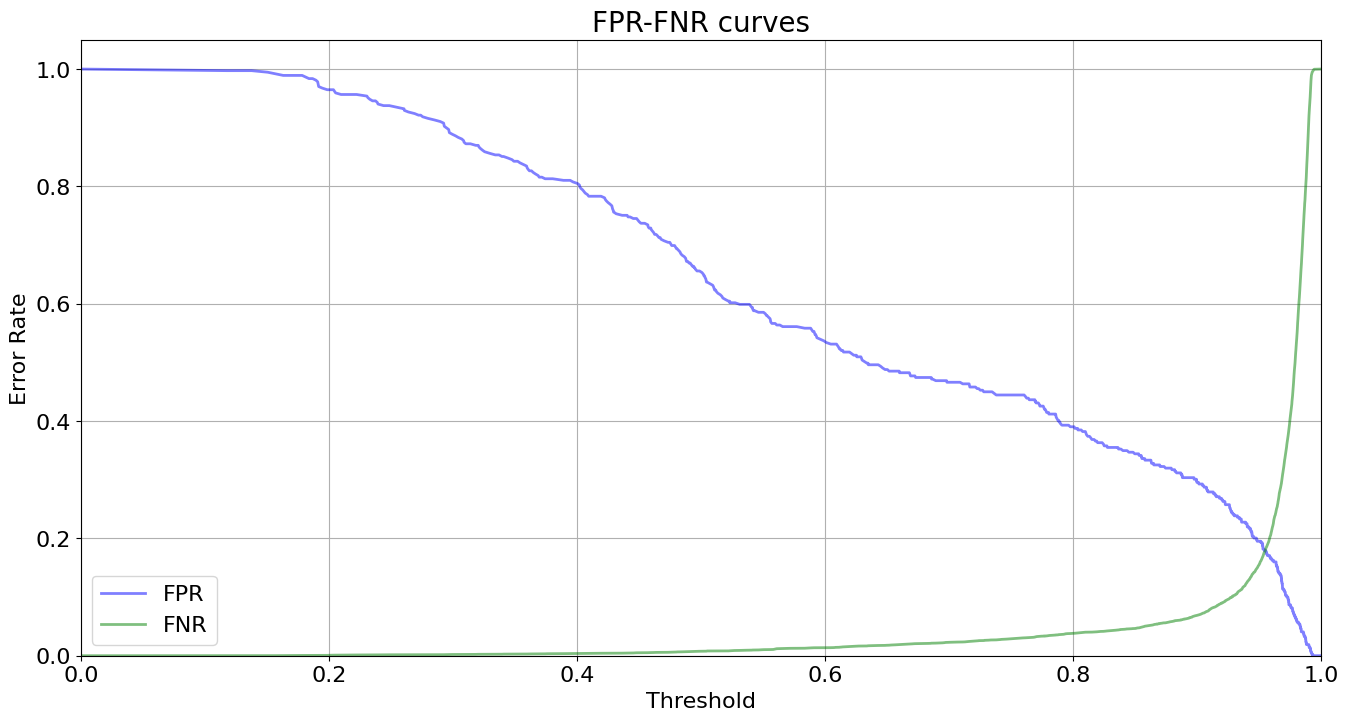

In [96]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color="blue", lw=lw, label="FPR", alpha=0.5)
plt.plot(thresholds, fnr, color="green", lw=lw, label="FNR", alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.title("FPR-FNR curves", fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [97]:
from catboost.utils import select_threshold

In [98]:
print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.5465141538095551
0.9918614587593035


Prediction obtaining

In [99]:
print(model.predict_proba(X_validation))

[[0.0115 0.9885]
 [0.0181 0.9819]
 [0.0165 0.9835]
 ...
 [0.0124 0.9876]
 [0.0097 0.9903]
 [0.0154 0.9846]]


In [100]:
print(model.predict(X_validation))

[1 1 1 ... 1 1 1]


Sequent predictions

In [101]:
predictions_gen = model.staged_predict_proba(
    data=X_validation, ntree_start=0, ntree_end=5, eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print("Iteration " + str(iteration) + ", predictions:")
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4794 0.5206]
 [0.4794 0.5206]
 [0.4794 0.5206]
 ...
 [0.4794 0.5206]
 [0.4794 0.5206]
 [0.4794 0.5206]]
Iteration 1, predictions:
[[0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]
 ...
 [0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]]
Iteration 2, predictions:
[[0.4397 0.5603]
 [0.4397 0.5603]
 [0.4397 0.5603]
 ...
 [0.4397 0.5603]
 [0.4397 0.5603]
 [0.4397 0.5603]]
Iteration 3, predictions:
[[0.4184 0.5816]
 [0.4184 0.5816]
 [0.4259 0.5741]
 ...
 [0.4184 0.5816]
 [0.4184 0.5816]
 [0.4184 0.5816]]
Iteration 4, predictions:
[[0.4004 0.5996]
 [0.4004 0.5996]
 [0.4078 0.5922]
 ...
 [0.4004 0.5996]
 [0.4004 0.5996]
 [0.4004 0.5996]]


Features importance

In [102]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,22.079715
1,MGR_ID,21.268923
2,ROLE_DEPTNAME,15.706984
3,ROLE_CODE,11.139762
4,ROLE_FAMILY_DESC,9.030437
5,ROLE_ROLLUP_2,7.401794
6,ROLE_TITLE,6.114111
7,ROLE_ROLLUP_1,4.060378
8,ROLE_FAMILY,3.197895


<b>Shap values</b>

Classic methods of measuring of features importance have a significant disadvantage - it isn't clear how each feature influence on model's prediction. Shap values is an approach of features importance measurment fixing this disadvantage.

Read mode: https://habr.com/ru/post/428213/

In [103]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [104]:
shap_values = model.get_feature_importance(pool1, type="ShapValues")

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

print(shap_values.shape)

(32769, 9)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


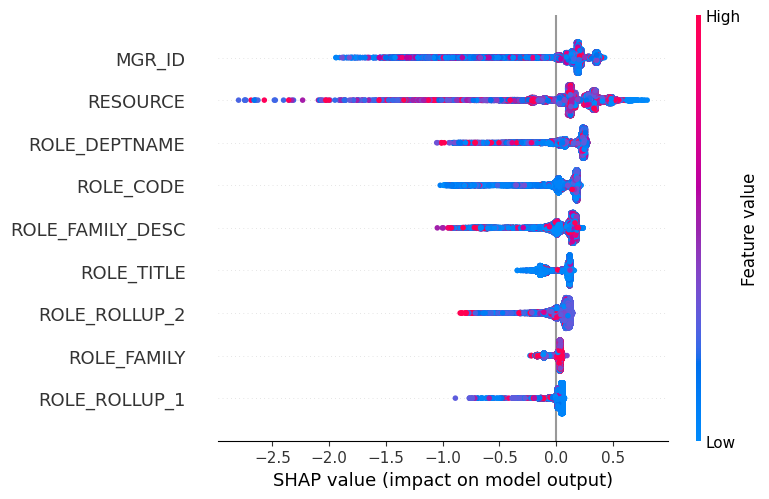

In [105]:
shap.summary_plot(shap_values, X)

Shap-values for particular object

In [106]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3, :], X.iloc[3, :])

Saving of the model

In [107]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train,
    y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
)
my_best_model.save_model("catboost_model.bin")
my_best_model.save_model("catboost_model.json", format="json")

In [108]:
my_best_model.load_model("catboost_model.bin")
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


Hyperparameters selection

In [109]:
cat = CatBoostClassifier(n_estimators=50)

grid = {"learning_rate": [0.03, 0.1], "depth": [4, 6, 10]}
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(
    grid, X=X_train, y=y_train, verbose=False, plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6563235	test: 0.6566072	best: 0.6566072 (0)	total: 10.6ms	remaining: 517ms
1:	learn: 0.6227275	test: 0.6234014	best: 0.6234014 (1)	total: 19.2ms	remaining: 462ms
2:	learn: 0.5915527	test: 0.5927244	best: 0.5927244 (2)	total: 28.1ms	remaining: 440ms
3:	learn: 0.5626480	test: 0.5641488	best: 0.5641488 (3)	total: 34.4ms	remaining: 395ms
4:	learn: 0.5360492	test: 0.5378118	best: 0.5378118 (4)	total: 40.3ms	remaining: 362ms
5:	learn: 0.5116681	test: 0.5137107	best: 0.5137107 (5)	total: 46.1ms	remaining: 338ms
6:	learn: 0.4891787	test: 0.4914464	best: 0.4914464 (6)	total: 52.7ms	remaining: 324ms
7:	learn: 0.4684688	test: 0.4710067	best: 0.4710067 (7)	total: 59.4ms	remaining: 312ms
8:	learn: 0.4494889	test: 0.4523627	best: 0.4523627 (8)	total: 67.5ms	remaining: 308ms
9:	learn: 0.4317228	test: 0.4348204	best: 0.4348204 (9)	total: 74.1ms	remaining: 297ms
10:	learn: 0.4155908	test: 0.4189671	best: 0.4189671 (10)	total: 80.5ms	remaining: 285ms
11:	learn: 0.4007153	test: 0.4044185	best

1:	learn: 0.6223371	test: 0.6231529	best: 0.6231529 (1)	total: 25.3ms	remaining: 607ms
2:	learn: 0.5908924	test: 0.5922279	best: 0.5922279 (2)	total: 38.1ms	remaining: 598ms
3:	learn: 0.5619197	test: 0.5637020	best: 0.5637020 (3)	total: 49.7ms	remaining: 572ms
4:	learn: 0.5350358	test: 0.5371230	best: 0.5371230 (4)	total: 62.9ms	remaining: 566ms
5:	learn: 0.5105299	test: 0.5128435	best: 0.5128435 (5)	total: 74.5ms	remaining: 546ms
6:	learn: 0.4877032	test: 0.4902443	best: 0.4902443 (6)	total: 87.5ms	remaining: 537ms
7:	learn: 0.4663720	test: 0.4692566	best: 0.4692566 (7)	total: 111ms	remaining: 582ms
8:	learn: 0.4470497	test: 0.4502992	best: 0.4502992 (8)	total: 122ms	remaining: 555ms
9:	learn: 0.4294047	test: 0.4328996	best: 0.4328996 (9)	total: 135ms	remaining: 540ms
10:	learn: 0.4128675	test: 0.4166674	best: 0.4166674 (10)	total: 145ms	remaining: 515ms
11:	learn: 0.3978405	test: 0.4019355	best: 0.4019355 (11)	total: 161ms	remaining: 511ms
12:	learn: 0.3840678	test: 0.3884521	best: 0

49:	learn: 0.1910230	test: 0.2093232	best: 0.2093232 (49)	total: 606ms	remaining: 0us

bestTest = 0.2093231793
bestIteration = 49

0:	learn: 0.6554959	test: 0.6557891	best: 0.6557891 (0)	total: 44.8ms	remaining: 2.19s
1:	learn: 0.6213557	test: 0.6221211	best: 0.6221211 (1)	total: 89.6ms	remaining: 2.15s
2:	learn: 0.5888624	test: 0.5901578	best: 0.5901578 (2)	total: 141ms	remaining: 2.21s
3:	learn: 0.5576150	test: 0.5593831	best: 0.5593831 (3)	total: 190ms	remaining: 2.18s
4:	learn: 0.5302613	test: 0.5325194	best: 0.5325194 (4)	total: 239ms	remaining: 2.15s
5:	learn: 0.5052728	test: 0.5080058	best: 0.5080058 (5)	total: 290ms	remaining: 2.13s
6:	learn: 0.4829720	test: 0.4860364	best: 0.4860364 (6)	total: 337ms	remaining: 2.07s
7:	learn: 0.4618221	test: 0.4654480	best: 0.4654480 (7)	total: 384ms	remaining: 2.02s
8:	learn: 0.4421396	test: 0.4462279	best: 0.4462279 (8)	total: 434ms	remaining: 1.98s
9:	learn: 0.4242653	test: 0.4287471	best: 0.4287471 (9)	total: 474ms	remaining: 1.9s
10:	lear

46:	learn: 0.1554458	test: 0.1913263	best: 0.1913263 (46)	total: 2.15s	remaining: 137ms
47:	learn: 0.1542845	test: 0.1909211	best: 0.1909211 (47)	total: 2.2s	remaining: 91.5ms
48:	learn: 0.1534887	test: 0.1908888	best: 0.1908888 (48)	total: 2.24s	remaining: 45.7ms
49:	learn: 0.1524291	test: 0.1904000	best: 0.1904000 (49)	total: 2.28s	remaining: 0us

bestTest = 0.1903999673
bestIteration = 49

Training on fold [0/3]
0:	learn: 0.5765176	test: 0.5776046	best: 0.5776046 (0)	total: 50.1ms	remaining: 2.46s
1:	learn: 0.4854912	test: 0.4881723	best: 0.4881723 (1)	total: 95.9ms	remaining: 2.3s
2:	learn: 0.4195686	test: 0.4229622	best: 0.4229622 (2)	total: 145ms	remaining: 2.27s
3:	learn: 0.3691423	test: 0.3733339	best: 0.3733339 (3)	total: 189ms	remaining: 2.18s
4:	learn: 0.3318539	test: 0.3364523	best: 0.3364523 (4)	total: 236ms	remaining: 2.12s
5:	learn: 0.2990979	test: 0.3047584	best: 0.3047584 (5)	total: 279ms	remaining: 2.04s
6:	learn: 0.2779697	test: 0.2838324	best: 0.2838324 (6)	total: 3

40:	learn: 0.1589331	test: 0.1892516	best: 0.1892516 (40)	total: 1.93s	remaining: 423ms
41:	learn: 0.1581372	test: 0.1888994	best: 0.1888994 (41)	total: 1.97s	remaining: 375ms
42:	learn: 0.1572605	test: 0.1886194	best: 0.1886194 (42)	total: 2.01s	remaining: 327ms
43:	learn: 0.1557039	test: 0.1880322	best: 0.1880322 (43)	total: 2.05s	remaining: 280ms
44:	learn: 0.1548497	test: 0.1879362	best: 0.1879362 (44)	total: 2.09s	remaining: 232ms
45:	learn: 0.1541536	test: 0.1874651	best: 0.1874651 (45)	total: 2.13s	remaining: 185ms
46:	learn: 0.1532606	test: 0.1870350	best: 0.1870350 (46)	total: 2.17s	remaining: 139ms
47:	learn: 0.1524004	test: 0.1868886	best: 0.1868886 (47)	total: 2.22s	remaining: 92.4ms
48:	learn: 0.1517146	test: 0.1865370	best: 0.1865370 (48)	total: 2.26s	remaining: 46.1ms
49:	learn: 0.1506432	test: 0.1863590	best: 0.1863590 (49)	total: 2.29s	remaining: 0us

bestTest = 0.1863589618
bestIteration = 49

Training on fold [2/3]
0:	learn: 0.5770292	test: 0.5776162	best: 0.5776162 

In [110]:
grid_search_result["params"]

{'depth': 10, 'learning_rate': 0.1}

Trees visualization

In [111]:
# Might run into the graphiz problem:
# https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [112]:
#cat.plot_tree(tree_idx=0)

Good description of catboost parameters: https://habr.com/ru/company/otus/blog/527554/

### LightGBM

Peculiarities:
* leaf-wise, not depth-wise trees building
* fast tree building allowing you not to encode categorical features, but to use the original categories to obtain predicates
* acceleration of trees building due to feature binarization (combining feature values into groups)

Read more: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [113]:
import lightgbm as lgb
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [114]:
data = fetch_california_housing()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=100, random_state=241
)

Training

In [115]:
print("Starting training...")
# train
gbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20)
gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="l1",
)

Starting training...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 20540, number of used features: 8
[LightGBM] [Info] Start training from score 2.069264


LGBMRegressor(learning_rate=0.05, n_estimators=20)

Prediction and quality metric

In [116]:
print("Starting predicting...")

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print("The rmse of prediction is:", mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print("Feature importances:", list(gbm.feature_importances_))

Starting predicting...
The rmse of prediction is: 0.6564125824100298
Feature importances: [120, 66, 20, 1, 3, 117, 132, 141]


You can use any quality metric (made by your own, for instance)

In [117]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return (
        "RMSLE",
        np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))),
        False,
    )


print("Starting training with custom eval function...")
# train
gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=rmsle,
)

print("Starting predicting...")
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print("The rmsle of prediction is:", rmsle(y_test, y_pred)[1])

Starting training with custom eval function...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 20540, number of used features: 8
[LightGBM] [Info] Start training from score 2.069264
Starting predicting...
The rmsle of prediction is: 0.2116324152785002


Hyperparameters selection

In [118]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {"learning_rate": [0.01, 0.1, 1], "n_estimators": [20, 40]}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print("Best parameters found by grid search are:", gbm.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13693, number of used features: 8
[LightGBM] [Info] Start training from score 2.068711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13693, number of used features: 8
[LightGBM] [Info] Start training from score 2.070758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13694, number of used features: 8
[LightGBM] [Info] Start traini

Prediction and quality metric

In [119]:
pred = gbm.predict(X_test)

In [120]:
from sklearn.metrics import mean_squared_error

In [121]:
mean_squared_error(y_test, pred)

0.18768978068555608